# 机器学习预测中国债卷市场收益项目文档
* 文档结构
    1. [数据预处理](#数据预处理)
    2. [模型拟合](#模型拟合)
    3. [结果保存及可视化](#结果保存及可视化)

<a name="数据预处理"></a>
## 数据预处理

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False   

### 数据载入
#### 将原数据转换成Parquet格式保存
-----------!!!!!!!!!-----------------
* **仅在首次运行此脚本或需要更新原始数据时运行以下代码框**
* **运行前需要在当前目录放置原文件夹"_./org_data/BondInputs.xlsx_"**

-----------!!!!!!!!!-----------------

In [ ]:
# 文件路径
excel_file_path = './org_data/BondInputs.xlsx'
parquet_file_path = './org_data/BondInputs.parquet'

# 读取 Excel 文件
data = pd.read_excel(excel_file_path)

# 转换并保存为 Parquet 格式
data.to_parquet(parquet_file_path, index=False)

print("数据已转换并保存为 Parquet 格式")

#### 读取Parquet格式原数据

In [504]:
# Parquet 文件路径
parquet_file_path = './org_data/BondInputs.parquet'

# 读取 Parquet 文件
orgdata_input = pd.read_parquet(parquet_file_path)

In [505]:
orgdata_input

,ID,Year_Month,End_of_Month_Dates,Year,Month,Day,"P_{i,t} + AI_{i,t}","C_{i,t}","P_{i,t-1} + AI_{i,t-1}",MonthlyTradingAmount,...,SMB,HML,MKT_Bond,MKT_Bond_constructed,DEF,TERM,beta_Bond,beta_Bond_constructed,beta_DEF,beta_TERM
0,112001,200803,733498,2008,3,31,101.332000,0.00,NaN,2.100177e+07,...,2.811978,-2.003422,2.410620,2.447491,1.996139,0.414481,NaN,NaN,NaN,NaN
1,112001,200804,733528,2008,4,30,101.154000,0.00,101.332000,8.150042e+07,...,-6.765342,-2.209811,-2.112579,-0.796580,-2.125033,0.012455,NaN,NaN,NaN,NaN
2,112001,200805,733558,2008,5,30,101.646000,0.00,101.154000,1.166635e+08,...,6.344506,1.269404,0.233232,0.068534,0.478702,-0.245470,NaN,NaN,NaN,NaN
3,112001,200806,733589,2008,6,30,101.833000,0.00,101.646000,6.295996e+06,...,-5.598665,-0.410980,-0.233740,0.036190,0.363643,-0.597383,NaN,NaN,NaN,NaN
4,112001,200807,733620,2008,7,31,102.200000,0.00,101.833000,1.493297e+06,...,8.184699,-1.503897,-0.449633,-0.295221,0.752335,-1.201968,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395987,131900011,202107,738358,2021,7,21,101.072279,3.64,104.173819,4.042772e+07,...,5.991544,-4.092572,0.706984,0.526568,-0.871557,1.578541,0.839941,0.798358,-0.283470,0.361938
395988,131900011,202108,738385,2021,8,17,101.281340,0.00,101.072279,4.051134e+07,...,2.285673,8.508192,0.079011,0.458221,0.025804,0.053207,0.839612,0.777427,-0.283923,0.362007
395989,131900011,202110,738454,2021,10,25,101.714149,0.00,NaN,1.017007e+08,...,-2.031312,-6.920226,0.006787,-0.285058,0.553537,-0.546751,0.839612,0.777427,-0.283923,0.362007
395990,131900011,202111,738464,2021,11,4,101.832175,0.00,101.714149,NaN,...,11.617931,-5.928053,0.250562,0.027262,-0.563837,0.814399,0.826195,0.779043,-0.244807,0.339364


### 设置索引和列名

In [506]:
# 重命名字典
variable_dict = {
    'Year_Month': 'YM',
    'End_of_Month_Dates': 'EOMD',
    'Year': 'YR',
    'Month': 'MTH',
    'Day': 'DY',
    'P_{i,t} + AI_{i,t}': 'PAI_T',
    'C_{i,t}': 'CIT',
    'P_{i,t-1} + AI_{i,t-1}': 'PAI_T1',
    'MonthlyTradingAmount': 'MTA',
    'MonthlyTradingVolume': 'MTV',
    'Rets': 'RET',
    'Excess_Rets': 'EX_RET',
    'Excess_Rets_ahead': 'EX_RET_AHD',
    'VaR': 'VAR',
    'VaR_10': 'VAR10',
    'VOL': 'VOL',
    'SKEW': 'SKEW',
    'KURT': 'KURT',
    'REV': 'REV',
    'ILLIQ': 'ILLIQ',
    'ILLIQ_ROLL': 'ILLIQ_R',
    'ILLIQ_Amihud': 'ILLIQ_A',
    'ILLIQ_Amihud_volume': 'ILLIQ_AV',
    'Turnover': 'TURNOV',
    'Turnover_amount': 'TURNOV_AMT',
    'Maturity': 'MAT',
    'Riskfree': 'RF',
    'Size': 'SZ',
    'Rating': 'RAT',
    'AmountIssued': 'AMT_ISS',
    'VolumeIssued': 'VOL_ISS',
    'CouponRate': 'COUP',
    'InterestFrenquency': 'INTRST_FRQ',
    'Type': 'TYPE',
    'RRiskfree(SHIBOR_3M)': 'RF_SHIBOR',
    'MKT': 'MKT',
    'SMB': 'SMB',
    'HML': 'HML',
    'MKT_Bond': 'MKT_B',
    'MKT_Bond_constructed': 'MKT_B_CON',
    'DEF': 'DEF',
    'TERM': 'TERM',
    'beta_Bond': 'BETA_B',
    'beta_Bond_constructed': 'BETA_B_CON',
    'beta_DEF': 'BETA_DEF',
    'beta_TERM': 'BETA_TERM'
}

In [507]:
orgdata_input.drop(['End_of_Month_Dates', 'Riskfree(SHIBOR_3M)'], axis=1)
renamedata = orgdata_input.rename(variable_dict, axis=1)

In [508]:
# 查看 orgdata_input 中的所有列
renamedata.columns

Index(['ID', 'YM', 'EOMD', 'YR', 'MTH', 'DY', 'PAI_T', 'CIT', 'PAI_T1', 'MTA',
       'MTV', 'RET', 'EX_RET', 'EX_RET_AHD', 'VAR', 'VAR10', 'VOL', 'SKEW',
       'KURT', 'REV', 'ILLIQ', 'ILLIQ_R', 'ILLIQ_A', 'ILLIQ_AV', 'TURNOV',
       'TURNOV_AMT', 'MAT', 'RF', 'SZ', 'RAT', 'AMT_ISS', 'VOL_ISS', 'COUP',
       'INTRST_FRQ', 'TYPE', 'Riskfree(SHIBOR_3M)', 'MKT', 'SMB', 'HML',
       'MKT_B', 'MKT_B_CON', 'DEF', 'TERM', 'BETA_B', 'BETA_B_CON', 'BETA_DEF',
       'BETA_TERM'],
      dtype='object')

#### 设置时间数据索引

In [509]:
# 合并时间相关列名
renamedata['TIME'] = renamedata['YR'].astype(str).str.cat(renamedata['MTH'].astype(str), sep='-')

# 转化为pandas时间格式
renamedata['date'] = pd.to_datetime(renamedata['TIME'])

# 将'date'列设置为索引
renamedata.set_index('date', inplace=True)

### 数据概览

#### 描述统计

In [510]:
# 要忽略的列列表
ignore_columns = ['TIME', 'ID', 'YM', 'EOMD', 'YR','MTH','DY']  # 非解释变量
macrovars = ['MKT', 'DEF', 'HML', 'MKT_B', 'MKT_B_CON', 'SMB', 'TERM', 'RF', 'Riskfree(SHIBOR_3M)'] # 宏观变量
ignore_columns.extend(macrovars)

In [511]:
# 用于检查的数据，排除忽略的列
data_for_check = renamedata.drop(columns=ignore_columns)

In [512]:
# 查看数据的统计描述
data_for_check.describe()

,PAI_T,CIT,PAI_T1,MTA,MTV,RET,EX_RET,EX_RET_AHD,VAR,VAR10,...,RAT,AMT_ISS,VOL_ISS,COUP,INTRST_FRQ,TYPE,BETA_B,BETA_B_CON,BETA_DEF,BETA_TERM
count,395992.000000,395900.000000,271446.000000,2.795830e+05,2.795830e+05,271374.000000,271374.000000,271374.000000,297498.000000,277067.000000,...,395992.000000,395792.000000,3.957920e+05,395992.000000,395992.000000,395992.000000,296861.000000,296861.000000,296861.000000,297498.000000
mean,101.042798,0.589205,101.197889,4.512326e+08,4.427052e+06,0.533903,0.258815,0.258815,1.177744,0.267452,...,1.872126,16.586355,1.658635e+07,5.388596,1.000194,11.277869,0.678260,1.100175,-0.244108,0.493981
std,11.042291,2.898950,10.418570,2.134977e+09,2.112282e+07,3.413503,3.416105,3.416105,1.954315,1.225019,...,0.917241,20.431620,2.043162e+07,1.323537,0.035640,7.079149,11.725452,22.493303,158.698511,45.253317
min,1.657803,0.000000,4.166705,1.820000e+02,1.000000e+01,-92.816752,-93.014542,-93.014542,-105.390805,-81.330546,...,0.000000,0.300000,3.000000e+05,0.100000,0.000000,2.000000,-2271.732581,-2704.626306,-86262.245699,-3830.106210
25%,100.607995,0.000000,100.589291,2.007266e+07,2.000000e+05,0.080708,-0.190937,-0.190937,0.188911,-0.159748,...,1.000000,7.000000,7.000000e+06,4.360000,1.000000,3.000000,0.231986,0.461689,-0.470694,0.089895
50%,102.779872,0.000000,102.757092,1.099093e+08,1.100000e+06,0.436974,0.171721,0.171721,0.811173,0.194777,...,2.000000,10.000000,1.000000e+07,5.300000,1.000000,17.000000,0.681597,1.004968,0.006231,0.409198
75%,104.954359,0.000000,104.947857,3.075090e+08,3.000000e+06,0.968803,0.701716,0.701716,1.713671,0.739127,...,3.000000,20.000000,2.000000e+07,6.300000,1.000000,17.000000,1.175260,1.646331,0.510341,0.766192
max,152.920208,107.000000,143.600000,1.795650e+11,1.793174e+09,616.775629,616.559991,616.559991,69.651453,41.769309,...,21.000000,300.000000,3.000000e+08,9.900000,4.000000,17.000000,586.717995,8068.397829,975.445182,23811.762762


#### 查看特征数值类型

In [513]:
# 查看数据类型
print(data_for_check.dtypes)

PAI_T         float64
CIT           float64
PAI_T1        float64
MTA           float64
MTV           float64
RET           float64
EX_RET        float64
EX_RET_AHD    float64
VAR           float64
VAR10         float64
VOL           float64
SKEW          float64
KURT          float64
REV           float64
ILLIQ         float64
ILLIQ_R       float64
ILLIQ_A       float64
ILLIQ_AV      float64
TURNOV        float64
TURNOV_AMT    float64
MAT           float64
SZ            float64
RAT             int64
AMT_ISS       float64
VOL_ISS       float64
COUP          float64
INTRST_FRQ      int64
TYPE            int64
BETA_B        float64
BETA_B_CON    float64
BETA_DEF      float64
BETA_TERM     float64
dtype: object


#### 检查重复行和债券个数

In [514]:
# 计算重复行数量
print("重复行数：", renamedata.duplicated().sum())

# 计算唯一债券数量
print("唯一债券数量：", renamedata['ID'].nunique())

重复行数： 0
唯一债券数量： 20613


### 缺失值处理

#### 可视化缺失情况

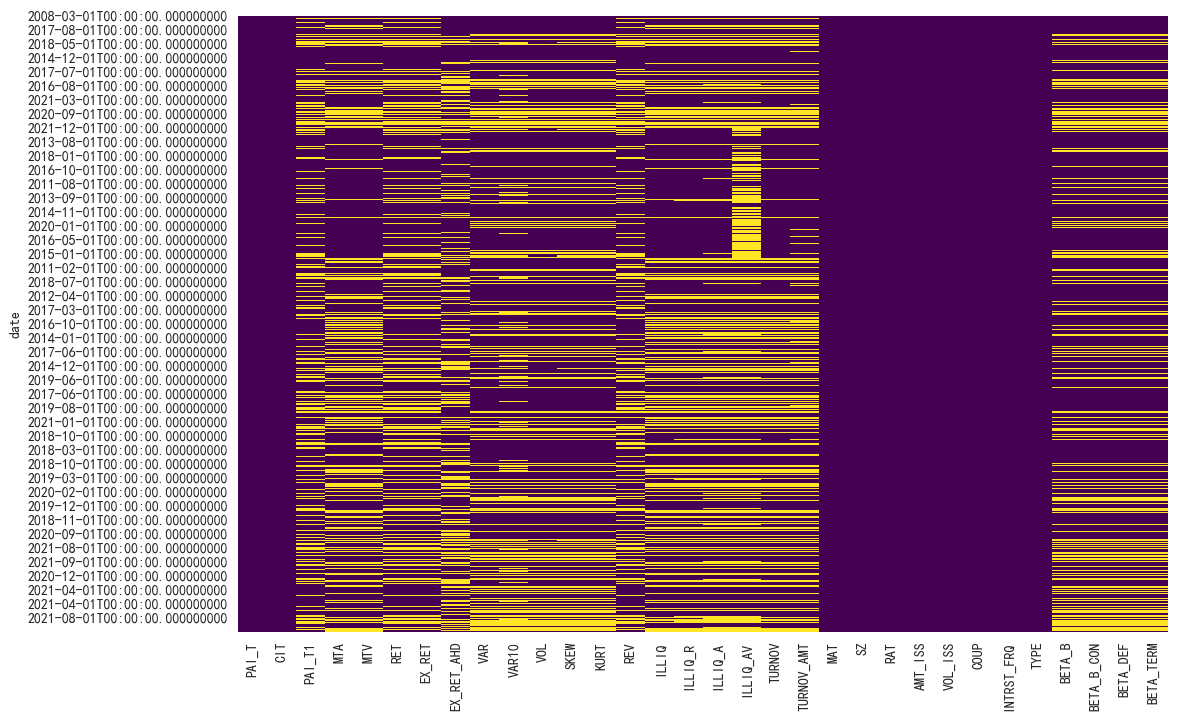

In [515]:
# 创建缺失值热图
plt.figure(figsize=(12, 8))
sns.heatmap(data_for_check.isnull(), cbar=False, cmap='viridis')
plt.show()

#### 分特征处理缺失值

In [516]:
# 查看数据类型
print(data_for_check.dtypes)

PAI_T         float64
CIT           float64
PAI_T1        float64
MTA           float64
MTV           float64
RET           float64
EX_RET        float64
EX_RET_AHD    float64
VAR           float64
VAR10         float64
VOL           float64
SKEW          float64
KURT          float64
REV           float64
ILLIQ         float64
ILLIQ_R       float64
ILLIQ_A       float64
ILLIQ_AV      float64
TURNOV        float64
TURNOV_AMT    float64
MAT           float64
SZ            float64
RAT             int64
AMT_ISS       float64
VOL_ISS       float64
COUP          float64
INTRST_FRQ      int64
TYPE            int64
BETA_B        float64
BETA_B_CON    float64
BETA_DEF      float64
BETA_TERM     float64
dtype: object


In [517]:
# 去除2007年的所有数据，MKT_Bond（债券市场因子月度收益率，以2007 年 12 月 31 日为基日，以 100 点为基点）
data_for_check = data_for_check[data_for_check.index.year > 2007]

In [518]:
# 定义缺失值处理方法字典
missing_method_dict = {'PAI_T1': 'bfill',#当月全价
    'ILLIQ': 'zero','ILLIQ_R': 'zero', 'ILLIQ_A': 'zero','ILLIQ_AV': 'zero','TURNOV': 'zero','TURNOV_AMT': 'zero','BETA_B': 'zero','BETA_B_CON': 'zero','BETA_DEF': 'zero','BETA_TERM': 'zero','REV': 'zero','VAR': 'zero','VAR10': 'zero','VOL': 'zero','SKEW': 'zero','KURT': 'zero','MTA': 'zero','MTV': 'zero','RET': 'zero','EX_RET': 'zero','EX_RET_AHD': 'zero','MAT': 'zero','SZ': 'zero','AMT_ISS': 'zero','VOL_ISS': 'zero'
     #要求当月至少有2个交易数据/过去36个月至少有5个收益数据
}

In [519]:
for feature, method in missing_method_dict.items():
    if feature not in data_for_check.columns:
        continue
    if method == "zero":
        data_for_check[feature] = data_for_check.groupby('date')[feature].transform(lambda x: x.fillna(x.median()))
    if method == "drop":
        data_for_check.drop(feature, axis=1, inplace=True)
    elif method == "bfill":
        data_for_check[feature].fillna(method='bfill', inplace=True)
        
data_for_check.fillna(0, inplace=True)

D:\python\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
D:\python\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
D:\python\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
D:\python\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [520]:
# 缺失值个数
data_for_check.isnull().sum().sum()

0

### 检查极端值及共线性情况

#### 检查共线性情况

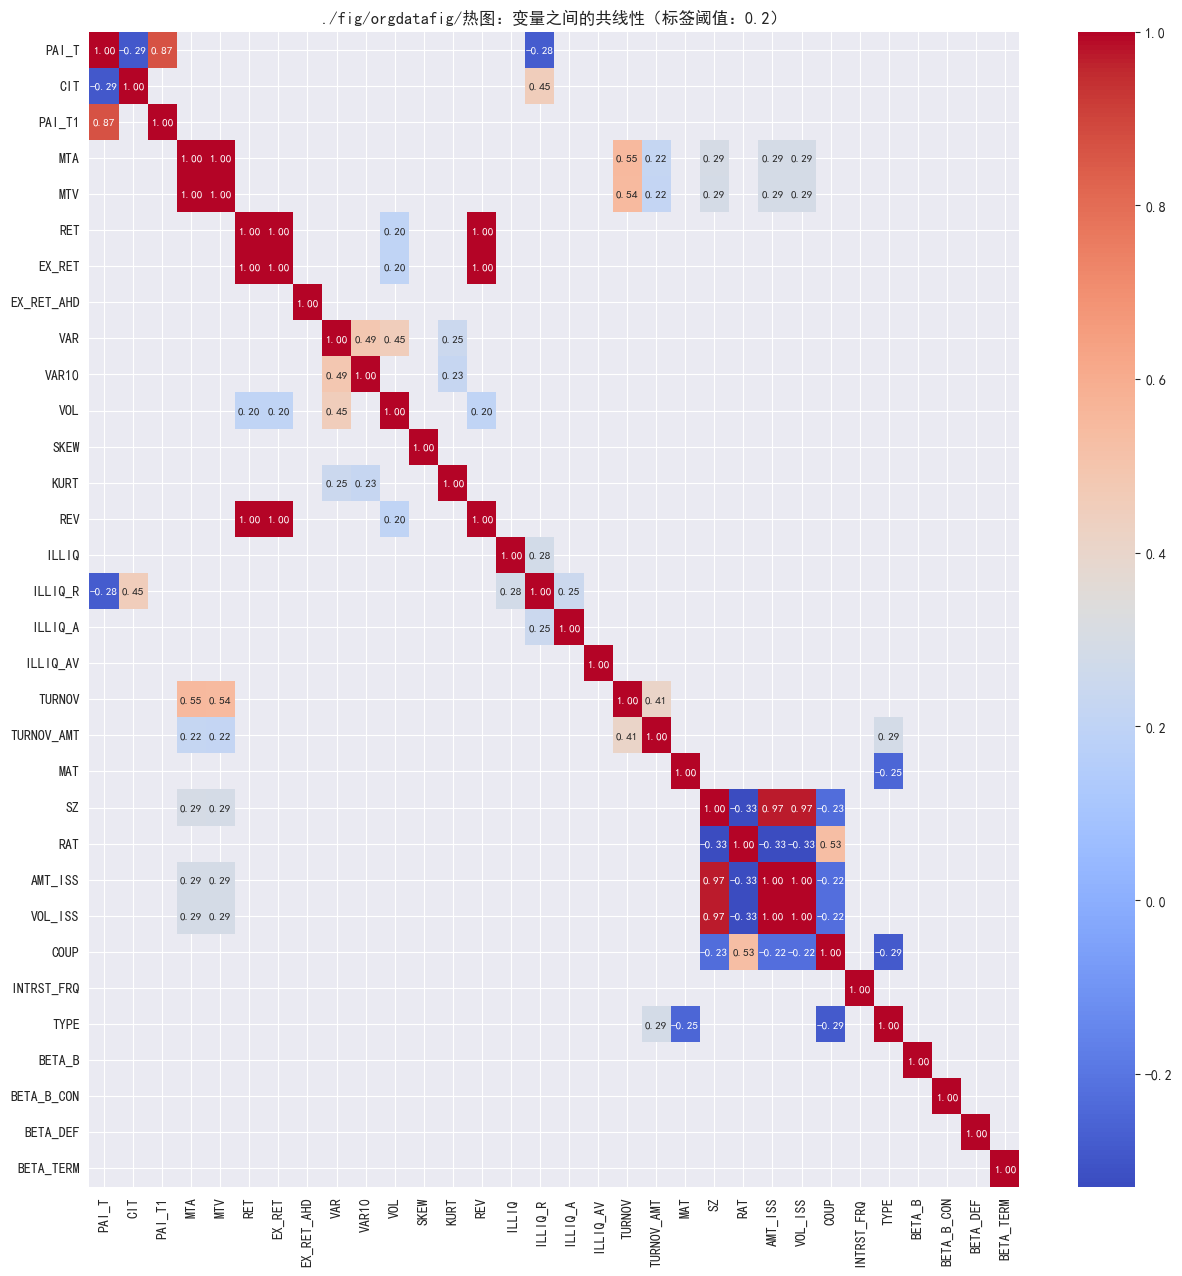

In [521]:
# 计算相关系数矩阵（忽略指定的列）
correlation_matrix = data_for_check.corr()

# 绘制相关系数热图
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
            mask= abs(correlation_matrix) < 0.2, annot_kws={"size": 8})
plt.title("./fig/orgdatafig/热图：变量之间的共线性（标签阈值：0.2）") # 注意需要现在当前目录下创建fig文件夹并在其中创建orgdatafig文件夹
plt.show()

In [522]:
samevars = ['MTA', 'ILLIQ_AV', 'AMT_ISS', 'TURNOV_AMT', 'SZ', 'REV', 'EX_RET', 'CIT', 'PAI_T1'] 

# 排除忽略的列
data_for_check = data_for_check.drop(columns=samevars, axis=1)

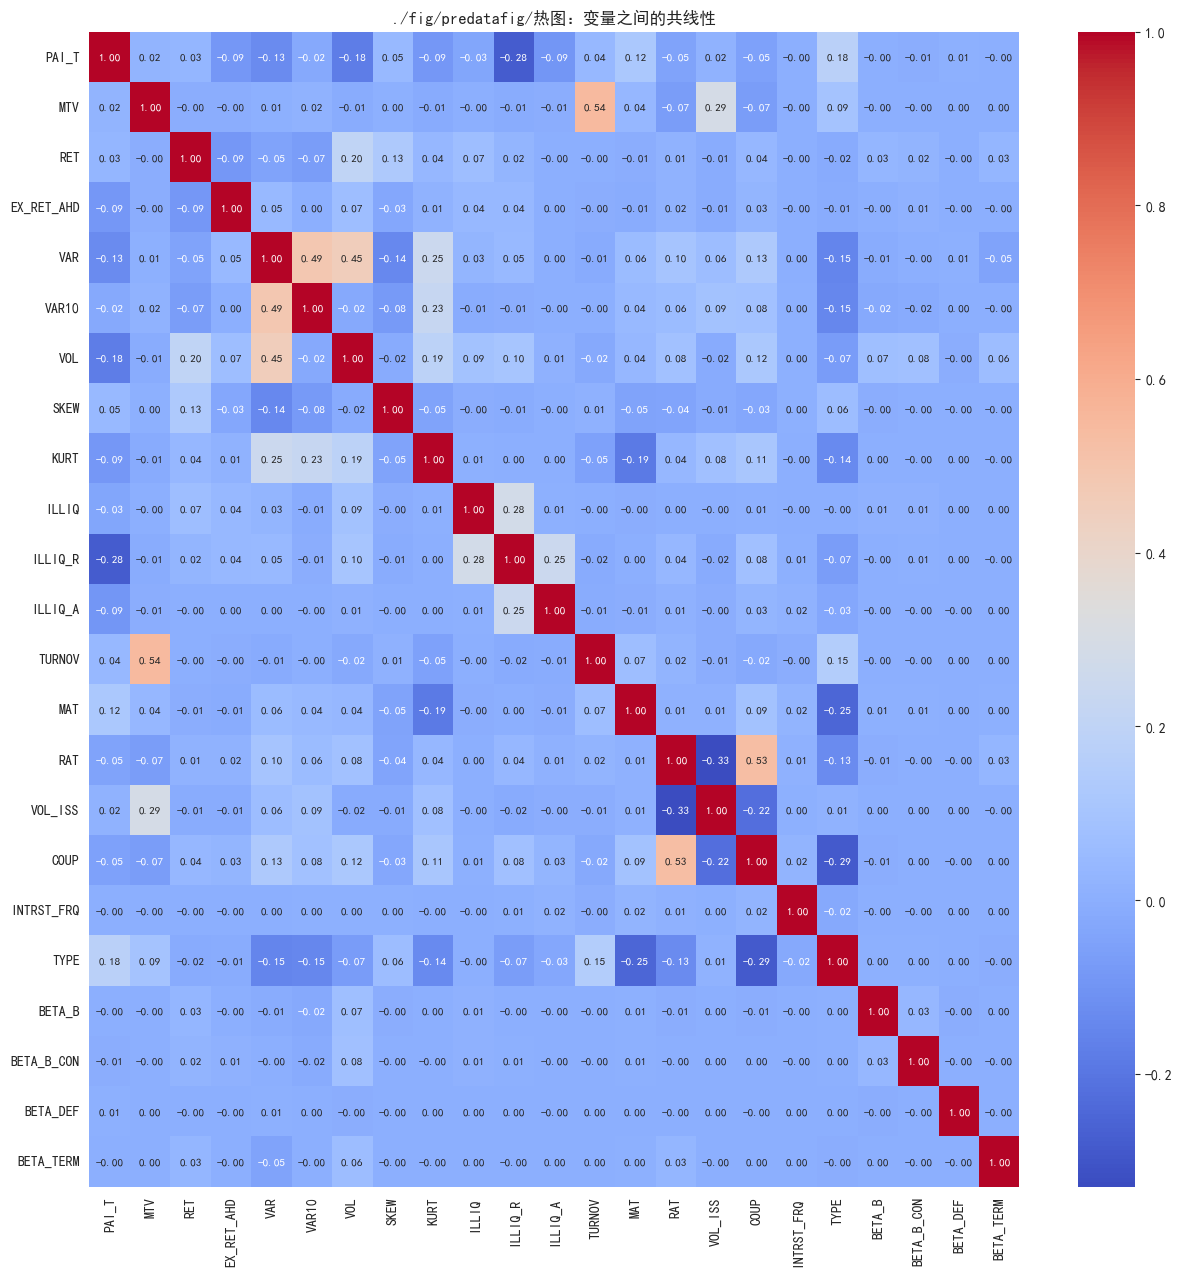

In [523]:
# 计算相关系数矩阵（忽略指定的列）
correlation_matrix = data_for_check.corr()

# 绘制相关系数热图
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', annot_kws={"size": 8})
plt.title("./fig/predatafig/热图：变量之间的共线性") # 注意需要现在当前目录下创建fig文件夹并在其中创建orgdatafig文件夹
plt.show()

#### 检查极端值

$\beta$ 相关数据的极端值

Beta 变量及其极端值数量： BETA_TERM      90
BETA_DEF      187
BETA_B_CON    203
BETA_B        147
dtype: int64


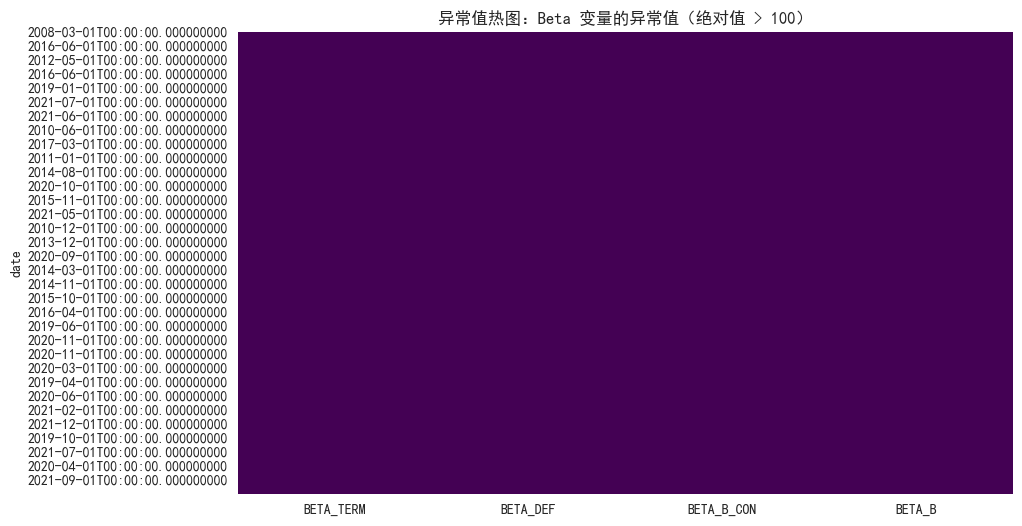

包含 Beta 异常值的行数： 559


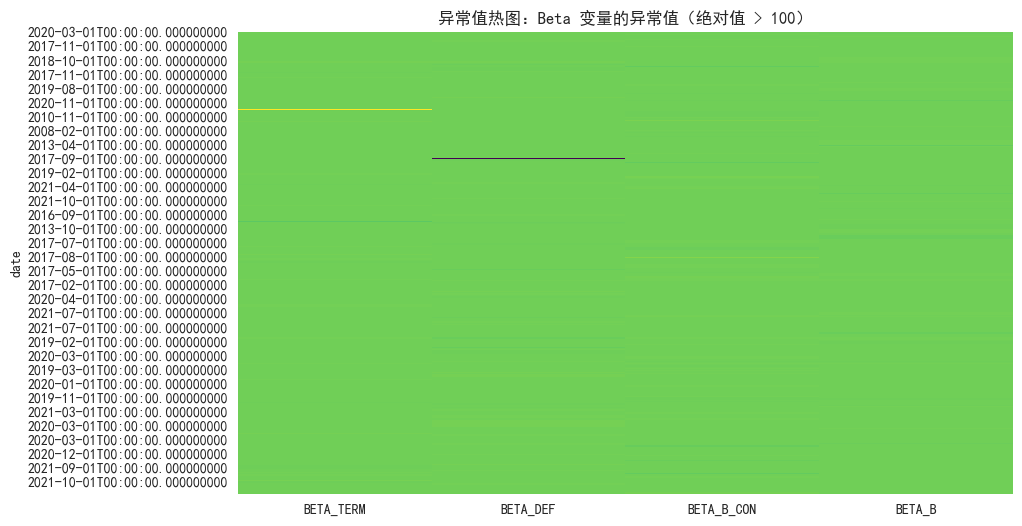

In [525]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 定义涉及到 beta 的列
beta_columns = ['BETA_TERM', 'BETA_DEF', 'BETA_B_CON', 'BETA_B']

# 创建一个空 DataFrame 来存储异常值
extreme_values_beta = pd.DataFrame()

# 找出并记录绝对值大于 100 的数据
for column in beta_columns:
    extreme_mask = data_for_check[column].abs() > 100
    extreme_values_beta[column] = extreme_mask

# 统计每列异常值的数量
extreme_values_count = extreme_values_beta.sum()
print("Beta 变量及其极端值数量：", extreme_values_count)

# 可视化异常值（热图）
plt.figure(figsize=(10, 6))
sns.heatmap(extreme_values_beta, cbar=False, cmap='viridis')
plt.title("异常值热图：Beta 变量的异常值（绝对值 > 100）")
plt.show()

# 创建一个新的 DataFrame，仅包含至少有一个 beta 异常值的行
rows_with_extreme_values = extreme_values_beta.any(axis=1)
filtered_data = data_for_check[rows_with_extreme_values]

# 统计这些行数
extreme_rows_count = filtered_data.shape[0]
print("包含 Beta 异常值的行数：", extreme_rows_count)


# 可视化异常值（热图）
plt.figure(figsize=(10, 6))
sns.heatmap(filtered_data[beta_columns], cbar=False, cmap='viridis')
plt.title("异常值热图：Beta 变量的异常值（绝对值 > 100）")
plt.show()


In [ ]:
for column in beta_columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(data_for_check[column], kde=True, bins=30)
    plt.title(f"分布图：{column}")
    plt.savefig(f'./fig/orgdatafig/{column}_distribution.png')  # 创建文件夹
    plt.show() 

* 极端小值：低于第一个四分位数的2倍四分位距的值
* 极端大值：高于第三个四分位数的2倍四分位距的值

In [526]:
# 极端值分析
extreme_values = {}

for column in data_for_check.columns.drop(column=beta_columns):
    Q1 = data_for_check[column].quantile(0.25)
    Q3 = data_for_check[column].quantile(0.75)
    IQR = Q3 - Q1
    extreme_count = ((data_for_check[column] < (Q1 - 2 * IQR)) | (data_for_check[column] > (Q3 + 2 * IQR))).sum()
    if extreme_count > 0:
        extreme_values[column] = extreme_count

print("变量及其极端值数量：", extreme_values)

变量及其极端值数量： {'PAI_T': 24806, 'MTV': 42253, 'RET': 43806, 'EX_RET_AHD': 46092, 'VAR': 17825, 'VAR10': 27242, 'VOL': 17171, 'SKEW': 24874, 'KURT': 25824, 'ILLIQ': 92135, 'ILLIQ_R': 38752, 'ILLIQ_A': 75788, 'TURNOV': 37712, 'MAT': 3778, 'RAT': 155, 'VOL_ISS': 19963, 'COUP': 31, 'INTRST_FRQ': 422, 'BETA_B': 35178, 'BETA_B_CON': 40008, 'BETA_DEF': 40969, 'BETA_TERM': 40184}


In [ ]:
for column in extreme_values.keys():
    plt.figure(figsize=(10, 6))
    sns.histplot(data_for_check[column], kde=True, bins=30)
    plt.title(f"分布图：{column}")
    plt.savefig(f'./fig/orgdatafig/{column}_distribution.png')  # 创建文件夹
    plt.show() 

In [529]:
# 定义涉及到 beta 的列
beta_columns = ['BETA_TERM', 'BETA_DEF', 'BETA_B_CON', 'BETA_B', 'ILLIQ_A', 'ILLIQ', 'RET', 'VAR', 'VAR10']

# 应用反正切变换并更新列名
for column in beta_columns:
    data_for_check['arctan_' + column] = np.arctan(data_for_check[column])
    data_for_check.drop(column, axis=1, inplace=True)

# 定义需要对数处理的列
log_columns = ['VOL_ISS', 'TURNOV', 'ILLIQ_R', 'VOL', 'MTV', 'MAT']

# 应用对数处理并更新列名
for column in log_columns:
    data_for_check['log1_' + column] = np.log1p(data_for_check[column])
    data_for_check.drop(column, axis=1, inplace=True)

In [ ]:
# 更新后的 beta_columns 列名
arctan_beta_columns = ['arctan_' + column for column in beta_columns]

# 可视化 arctan 变换后的列
for column in arctan_beta_columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(data_for_check[column], kde=True, bins=30)
    plt.title(f"分布图：{column}")
    plt.savefig(f'./fig/predatafig/{column}_distribution.png')  # 创建文件夹
    plt.show()

# 更新后的 log_columns 列名
log1_columns = ['log1_' + column for column in log_columns]

# 可视化 log1p 变换后的列
for column in log1_columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(data_for_check[column], kde=True, bins=30)
    plt.title(f"分布图：{column}")
    plt.savefig(f'./fig/predatafig/{column}_distribution.png')  # 创建文件夹
    plt.show()

### 数据标准化

#### 数据预览

In [537]:
data_for_check

,PAI_T,EX_RET_AHD,SKEW,KURT,RAT,COUP,INTRST_FRQ,TYPE,arctan_BETA_TERM,arctan_BETA_DEF,...,arctan_ILLIQ,arctan_RET,arctan_VAR,arctan_VAR10,log1_VOL_ISS,log1_TURNOV,log1_ILLIQ_R,log1_VOL,log1_MTV,log1_MAT
date,,,,,,,,,,,,,,,,,,,,,
2008-03-01,101.332000,-0.458652,-0.294038,3.201574,1,5.50,1,2,0.551861,0.398860,...,0.126805,1.230457,1.251876,0.877031,16.811243,0.714618,0.000000,1.300033,12.248567,2.072417
2008-04-01,101.154000,0.188933,-0.127132,3.244590,1,5.50,1,2,0.506463,0.566636,...,-0.000342,-0.173886,1.274354,0.959348,16.811243,1.620729,0.130294,1.284814,13.606462,2.062168
2008-05-01,101.646000,-0.136307,-0.196254,3.265799,1,5.50,1,2,0.685244,0.550944,...,0.001818,0.452698,1.284611,0.981734,16.811243,1.916236,0.094020,1.290316,13.963126,2.051556
2008-06-01,101.833000,0.078885,-0.264337,3.244504,1,5.50,1,2,0.612913,0.539827,...,0.002916,0.181937,1.276640,0.960535,16.811243,0.273026,0.107943,1.285636,11.047519,2.040701
2008-07-01,102.200000,0.570645,-0.151292,3.322650,1,5.50,1,2,0.544116,0.451635,...,0.010105,0.345904,1.247283,0.967798,16.811243,0.071897,0.180362,1.298521,9.609787,2.029463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-01,101.072279,0.015115,-1.131452,5.605950,1,3.64,1,17,0.347270,-0.276224,...,-0.007120,0.477065,0.455016,0.331755,17.216708,0.847298,0.326624,0.397824,12.899222,0.666775
2021-08-01,101.281340,-0.021192,-1.136623,5.821729,1,3.64,1,17,0.347332,-0.276643,...,0.006381,0.203966,0.455016,0.331755,17.216708,0.847298,0.070641,0.390390,12.899222,0.628061
2021-10-01,101.714149,-0.081637,-1.136623,5.821729,1,3.64,1,17,0.347332,-0.276643,...,-0.002622,0.192380,0.455016,0.331755,17.216708,1.466337,0.299677,0.390390,13.815512,0.521725


In [538]:
data_for_check.describe()

,PAI_T,EX_RET_AHD,SKEW,KURT,RAT,COUP,INTRST_FRQ,TYPE,arctan_BETA_TERM,arctan_BETA_DEF,...,arctan_ILLIQ,arctan_RET,arctan_VAR,arctan_VAR10,log1_VOL_ISS,log1_TURNOV,log1_ILLIQ_R,log1_VOL,log1_MTV,log1_MAT
count,394904.000000,394904.000000,3.949040e+05,394904.000000,394904.000000,394904.000000,394904.000000,394904.000000,394904.000000,394904.000000,...,394904.000000,394904.000000,394904.000000,394904.000000,394904.000000,394904.000000,394904.000000,394904.000000,394904.000000,394904.000000
mean,101.042068,0.229888,-2.700461e-02,3.549871,1.874256,5.390749,1.000152,11.300688,0.338743,0.011853,...,0.089112,0.351771,0.599023,0.195663,16.272350,2.257109,0.410707,0.795400,13.421515,1.257347
std,11.052770,2.833438,7.928074e-01,2.097184,0.917209,1.324471,0.035081,7.075514,0.447979,0.576551,...,0.370603,0.552566,0.492834,0.488673,0.779649,1.250557,0.516917,0.350040,2.356059,0.516586
min,1.657803,-93.014542,-5.325164e+00,1.000000,0.000000,0.100000,0.000000,2.000000,-1.570535,-1.570785,...,-1.570660,-1.560023,-1.561308,-1.558501,12.611541,0.000005,0.000000,0.000000,2.397895,0.002996
25%,100.612662,-0.098040,-3.446603e-01,2.464001,1.000000,4.360000,1.000000,3.000000,0.201535,-0.303274,...,0.000000,0.152202,0.292179,-0.027422,15.761421,1.609438,0.114384,0.587800,13.122268,0.928097
50%,102.782000,0.179208,-2.311726e-16,3.055499,2.000000,5.300000,1.000000,17.000000,0.393018,-0.003598,...,0.003905,0.411431,0.690735,0.177539,16.118096,2.397895,0.246832,0.779526,13.997833,1.308063
75%,104.955000,0.511598,2.831803e-01,3.913462,3.000000,6.300000,1.000000,17.000000,0.561987,0.325614,...,0.049022,0.666005,0.974223,0.511050,16.811243,2.908721,0.519478,0.948568,14.508658,1.651290
max,152.920208,616.559991,5.721504e+00,33.841207,21.000000,9.900000,4.000000,17.000000,1.570754,1.569771,...,1.570789,1.569175,1.556440,1.546860,19.519293,8.138778,6.576852,5.548638,21.307253,3.277258


In [539]:
# 缺失值个数
data_for_check.isnull().sum().sum()

0

In [542]:
# 定义分类变量名称列表
categorical_features = ['INTRST_FRQ', 'TYPE', 'RAT']

以下代码实现了两种不同的数据标准化方法：基于排名的标准化和基于分布的标准化。

### 一、依排名标准化

* `calculate_parameters_by_date` 函数

此函数旨在为每个特征计算基于时间截面的最小和最大排名。

* 参数
- `data`: 数据集。
- `categorical_features`: 需要排除的分类变量名称列表。

* 功能
- 遍历数据中每个时间截面的分组。
- 对每组数据（排除分类变量后），计算每个特征的最小和最大排名。
- 返回包含这些排名的字典。

#### `apply_cross_sectional_scaling` 函数

此函数使用 `calculate_parameters_by_date` 函数的输出来对数据进行标准化。

* 参数
- `data`: 要处理的数据集。
- `min_ranks_by_date`: 每个时间截面的最小排名。
- `max_ranks_by_date`: 每个时间截面的最大排名。
- `categorical_features`: 分类变量的名称列表。

* 功能
- 对数据集中的每个时间截面，使用计算的排名来标准化数据。
- 返回标准化后的数据集。

In [558]:
def calculate_parameters_by_date(data, categorical_features):
    """
    按照时间截面计算每个特征的最小和最大排名
    :param data: 数据集
    :param non_time_varying_features: 月度不变变量的名称列表
    :return: 按照时间截面的最小和最大排名的字典
    """
    min_ranks_by_date = {}
    max_ranks_by_date = {}
    for name, group in data.groupby(level=0):
        min_ranks = group.drop(columns=categorical_features).rank().min()
        max_ranks = group.drop(columns=categorical_features).rank().max()
        min_ranks_by_date[name] = min_ranks
        max_ranks_by_date[name] = max_ranks
    return min_ranks_by_date, max_ranks_by_date

def apply_cross_sectional_scaling(data, min_ranks_by_date, max_ranks_by_date, categorical_features):
    """
    使用按照时间截面计算的参数对数据进行标准化
    :param data: 要处理的数据
    :param min_ranks_by_date: 按照时间截面的最小排名
    :param max_ranks_by_date: 按照时间截面的最大排名
    :param categorical_features: 分类变量的名称列表
    :return: 处理后的数据
    """
    scaled_data = data.copy()
    for name, group in data.groupby(level=0):
        min_ranks = min_ranks_by_date[name]
        max_ranks = max_ranks_by_date[name]
        ranks = group.drop(columns=categorical_features).rank()
        scaled_group = 2 * (ranks + min_ranks) / (max_ranks + min_ranks) - 1
        scaled_data.loc[name, scaled_group.columns] = scaled_group
    return scaled_data

### 二、依分布标准化

#### `standardize_data` 函数

此函数使用训练集的均值和标准差对数据集进行标准化。

* 参数
- `train`: 训练数据集。
- `val`: 验证数据集。
- `test`: 测试数据集。
- `categorical_features`: 分类变量的名称列表。
- 
* 功能
- 计算训练集（排除分类变量后）的均值和标准差。
- 使用这些统计数据来标准化训练集、验证集和测试集。
- 将分类变量重新添加到标准化后的数据集中。
- 返回标准化后的数据集。

In [559]:
def standardize_data(train, val, test, categorical_features):
    """
    使用训练集的均值和标准差对训练集、验证集和测试集进行标准化
    :param train: 训练集数据
    :param val: 验证集数据
    :param test: 测试集数据
    :param categorical_features: 分类变量的名称列表
    :return: 标准化后的训练集、验证集和测试集
    """
    # 计算训练集的均值和标准差
    means = train.drop(columns=categorical_features).mean()
    stds = train.drop(columns=categorical_features).std()

    # 标准化训练集、验证集和测试集
    train_scaled = (train.drop(columns=categorical_features) - means) / stds
    val_scaled = (val.drop(columns=categorical_features) - means) / stds
    test_scaled = (test.drop(columns=categorical_features) - means) / stds

    # 将分类变量重新添加到数据中
    train_scaled[categorical_features] = train[categorical_features]
    val_scaled[categorical_features] = val[categorical_features]
    test_scaled[categorical_features] = test[categorical_features]

    return train_scaled, val_scaled, test_scaled


### 训练集、测试集、验证集划分

本段代码主要实现了交叉验证的数据集构建流程，包括了数据预处理的步骤和一个用于保存预处理后数据的函数。

#### 交叉验证函数 `cross_validation`

此函数用于执行基于时间序列的交叉验证。它支持滚动窗口和固定窗口两种模式，并提供了不同的数据标准化方法。

* 参数
- `data`: 数据集。
- `start_year`: 开始年份，用于确定交叉验证的起始点。
- `rolling`: 布尔值，指定是否使用滚动窗口。
- `standardization_method`: 选择的标准化方法，如 'ranking' 或 'distribution'。
- `categorical_features`: 分类变量的列表。

* 功能
- 根据 `start_year` 和数据中的独特年份创建训练、验证和测试集。
- 如果 `rolling` 为 `True`，则使用滚动窗口划分数据；如果为 `False`，则使用固定窗口。
- 根据选择的标准化方法对数据进行标准化处理。
- 使用 `yield` 生成器返回每个划分的训练集、验证集和测试集。

#### 数据保存函数 `save_preprocessed_data`

此函数用于将预处理后的数据保存为 Parquet 格式，便于后续的高效读取。

* 参数
- `X`: 特征数据。
- `y`: 目标变量。
- `name`: 保存的文件名。
- `prefix`: 文件名前缀。
- `folder`: 保存文件的文件夹。

* 功能
- 将特征数据和目标变量合并。
- 创建指定的文件夹（如果不存在）。
- 将合并后的数据保存为 Parquet 格式。

In [560]:
def cross_validation(data, start_year, rolling=True, standardization_method='ranking', categorical_features=[]):
    unique_years = sorted(data.index.year.unique())
    start_idx = unique_years.index(start_year)
    
    y_data = data['EX_RET_AHD']
    X_data = data.drop(columns=['EX_RET_AHD'])
    
    for i in range(start_idx, len(unique_years) - 4):
        train_end_year = unique_years[i]
        val_start_year = train_end_year + 1
        val_end_year = val_start_year + 2
        test_year = val_end_year + 1

        if rolling:
            train_data = X_data[(X_data.index.year <= train_end_year) & (train_end_year-2 <= X_data.index.year)]
            train_y = y_data[(y_data.index.year <= train_end_year) & (train_end_year-2 <= y_data.index.year)]
        else:
            train_data = X_data[X_data.index.year <= train_end_year]
            train_y = y_data[y_data.index.year <= train_end_year]

        val_data = X_data[(X_data.index.year >= val_start_year) & (X_data.index.year <= val_end_year)]
        val_y = y_data[(y_data.index.year >= val_start_year) & (y_data.index.year <= val_end_year)]
        test_data = X_data[X_data.index.year == test_year]
        test_y = y_data[y_data.index.year == test_year]

        # 根据选择的标准化方法应用标准化
        if standardization_method == 'ranking':
            min_ranks_by_date, max_ranks_by_date = calculate_parameters_by_date(X_data, categorical_features)
            scaled_train = apply_cross_sectional_scaling(train_data, min_ranks_by_date, max_ranks_by_date, categorical_features)
            scaled_val = apply_cross_sectional_scaling(val_data, min_ranks_by_date, max_ranks_by_date, categorical_features)
            scaled_test = apply_cross_sectional_scaling(test_data, min_ranks_by_date, max_ranks_by_date, categorical_features)
        else:
            scaled_train, scaled_val, scaled_test = standardize_data(train_data, val_data, test_data, categorical_features)

        yield scaled_train, train_y, scaled_val, val_y, scaled_test, test_y


In [561]:
import os

def save_preprocessed_data(X, y, name, prefix='', folder=''):
    """
    修改后的数据保存方法，将数据保存为 Parquet 格式。
    """
    # 将目标特征 y 添加到数据 X 的最后一列
    data = pd.concat([X, y], axis=1)

    # 构建文件夹路径
    folder_path = f'./Preprocessed data/{folder}'
    
    # 检查是否存在文件夹，如果不存在则创建
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    # 保存数据到指定文件
    data.to_parquet(os.path.join(folder_path, f'{prefix}{name}.parquet'))

start_year = 2010
rolling_options = [True, False]
standardization_methods = ['ranking', 'distribution']

for rolling in rolling_options:
    for method in standardization_methods:
        folder_name = f'rolling_{rolling}_method_{method}'
        for train_X, train_y, val_X, val_y, test_X, test_y in cross_validation(data_for_check, start_year, rolling, method):
            prefix = f'{train_X.index.max().year}_'
            save_preprocessed_data(train_X, train_y, 'train_data', prefix, folder_name)
            save_preprocessed_data(val_X, val_y, 'val_data', prefix, folder_name)
            save_preprocessed_data(test_X, test_y, 'test_data', prefix, folder_name)


<a name="模型拟合"></a>
## 模型拟合

In [9]:
import numpy as np
import gc
from tqdm import tqdm

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.decomposition import PCA
from sklearn.linear_model import HuberRegressor, ElasticNet, LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import PolynomialFeatures

from skopt import BayesSearchCV
from skopt.space import Real

### 自定义 R2 分数计算函数

以下是一个自定义的 R² 分数计算函数的实现及其数学解释。

#### 参数设置

函数 `custom_r2_score` 接受两个参数：`y_true` 和 `y_pred`。这两个参数分别代表观测值和模型预测值。


#### 数学解释

R² 分数的计算公式如下：

$$ R^2 = 1 - \frac{\sum_{i=1}^{n} (y_{\text{true},i} - y_{\text{pred},i})^2}{\sum_{i=1}^{n} y_{\text{true},i}^2} $$

其中，
- $ y_{\text{true},i} $ 是第 $ i $ 个观测值。
- $ y_{\text{pred},i} $ 是第 $ i $ 个预测值。
- 分子 $\sum_{i=1}^{n} (y_{\text{true},i} - y_{\text{pred},i})^2$ 是残差平方和，即观测值与预测值差异的平方和。
- 分母 $\sum_{i=1}^{n} y_{\text{true},i}^2$ 是观测值的平方和。

In [23]:
# 自定义 R2 分数计算函数
def custom_r2_score(y_true, y_pred):
    numerator = np.sum((y_true - y_pred) ** 2)
    denominator = np.sum(y_true ** 2)
    return 1 - numerator / denominator

### 数据加载和处理函数

负责从存储文件中加载数据，并根据特定的条件对数据进行预处理。

#### 函数参数

- `year`: 指定要加载数据的年份。
- `rolling`: 布尔值，指定是否使用滚动方法。
- `standardization_method`: 字符串，指定使用的标准化方法。
- `ignore_unstable_features`: 布尔值，指定是否忽略不稳定的特征。

#### 功能描述

   1. **路径构建**：函数首先根据提供的 `rolling` 和 `standardization_method` 参数构建文件夹路径。
    
   2. **数据加载**：然后从构建的路径中加载对应年份的训练集、验证集和测试集数据。这里使用的是 Parquet 格式，一种高效的列存储格式。
    
   3. **特征剔除**：如果 `ignore_unstable_features` 参数设置为 `True`，函数会从所有数据集中移除不稳定的特征。这些特征在 `unstable_features` 列表中定义。
    
   4. **返回数据**：最后，函数返回处理后的训练集、验证集和测试集数据。


In [24]:
def load_and_process_data(year, rolling, standardization_method, ignore_unstable_features):
    folder_prefix = f"rolling_{rolling}_method_{standardization_method}"
    train_data = pd.read_parquet(f'./Preprocessed data/{folder_prefix}/{year}_train_data.parquet')
    val_data = pd.read_parquet(f'./Preprocessed data/{folder_prefix}/{year}_val_data.parquet')
    test_data = pd.read_parquet(f'./Preprocessed data/{folder_prefix}/{year}_test_data.parquet')
    unstable_features = ['CIT', 'INTRST_FRQ']

    if ignore_unstable_features:
        train_data.drop(columns=unstable_features, errors='ignore', inplace=True)
        val_data.drop(columns=unstable_features, errors='ignore', inplace=True)
        test_data.drop(columns=unstable_features, errors='ignore', inplace=True)

    return train_data, val_data, test_data


### 时间滚动交叉验证函数

`time_rolling_cv` 函数是为了执行时间滚动的交叉验证而设计。


#### 参数说明

- `models`: 一个包含模型及其参数网格的字典。
- `start_year`: 分析的起始年份。
- `end_year`: 分析的结束年份。
- `rolling`: 是否使用滚动窗口方法。
- `standardization_method`: 数据标准化方法，可以是 'ranking' 或 'distribution'。
- `ignore_unstable_features`: 是否忽略不稳定的特征。

#### 功能描述

1. **初始化结果存储结构**：为每个模型创建一个字典来存储 R² 分数、参数和特征计数。

2. **遍历模型**：对于提供的每个模型，执行以下步骤：

   - **数据加载和处理**：对于指定的年份范围，使用 `load_and_process_data` 函数加载和处理数据。
   - **数据准备**：准备训练集、验证集和测试集，并合并训练集和验证集用于模型参数的网格搜索。
   - **模型训练和验证**：使用预定义的分割方法 (`PredefinedSplit`) 进行网格搜索以找到最佳模型参数。然后，使用训练集对模型进行训练。
   - **模型评估**：使用自定义的 R² 分数函数评估模型在训练集和测试集上的表现。
   - **存储结果**：存储每个年份的 R² 分数、最佳参数和特征计数。
   - **清理内存**：删除不再使用的变量以节省内存。

#### 返回值

函数返回一个包含每个模型在不同年份和不同设置下的表现结果的字典。


In [25]:
rolling_options=[False, True]
standardization_methods=['ranking', 'distribution']

def time_rolling_cv(models, start_year=2010, end_year=2017, rolling=False, standardization_method='ranking', ignore_unstable_features=False):
    results = {model_name: {"r2_scores": [], "params": [], "feature_counts": []} for model_name in models.keys()}

    for model_name, model_info in models.items():
        all_y_test = []
        all_y_pred = []

        for year in tqdm(range(start_year, end_year + 1)):
            train_data, val_data, test_data = load_and_process_data(year, rolling, standardization_method, ignore_unstable_features)

            X_train, y_train = train_data.drop(columns='EX_RET_AHD'), train_data['EX_RET_AHD']
            X_val, y_val = val_data.drop(columns='EX_RET_AHD'), val_data['EX_RET_AHD']
            X_test, y_test = test_data.drop(columns='EX_RET_AHD'), test_data['EX_RET_AHD']

            X_combined = np.vstack((X_train, X_val))
            y_combined = np.concatenate((y_train, y_val))
            test_fold = np.array([-1] * len(X_train) + [0] * len(X_val))
            ps = PredefinedSplit(test_fold)

            del X_val, y_val, train_data, val_data, test_data
            gc.collect()

            model, param_grid = model_info["model"], model_info["param_grid"]
            search_cv = model_info.get("search_cv", GridSearchCV)

            grid_search = search_cv(model, param_grid, cv=ps)
            grid_search.fit(X_combined, y_combined)

            best_model = grid_search.best_estimator_
            best_model.fit(X_train, y_train)

            y_pred = best_model.predict(X_test).ravel()
            y_train_pred = best_model.predict(X_train).ravel()

            y_train = y_train.ravel()
            y_test = y_test.ravel()

            all_y_test.extend(y_test)
            all_y_pred.extend(y_pred)

            r2_in_sample = custom_r2_score(y_train, y_train_pred)
            r2_out_of_sample = custom_r2_score(y_test, y_pred)
            results[model_name]["r2_scores"].append((year, r2_in_sample, r2_out_of_sample))

            results[model_name]["params"].append((year, grid_search.best_params_))

            feature_count = X_train.shape[1]
            results[model_name]["feature_counts"].append((year, feature_count))

            del X_train, y_train, X_test, y_test, X_combined, y_combined
            gc.collect()

        r2_custom = custom_r2_score(np.array(all_y_test), np.array(all_y_pred))
        results[model_name]["r2_scores"].append(("Overall", r2_custom))

    return results


### 自定义弹性网络结合Huber回归

在以下代码段中，定义了一个自定义的机器学习模型 `ElasticNetWithHuber`，结合了弹性网回归（Elastic Net）和Huber回归。这个类继承了 `BaseEstimator` 和 `RegressorMixin`，使其能够与scikit-learn库的其他功能兼容。


#### 构造函数 `__init__`

- `alpha`: 正则化强度。
- `l1_ratio`: 用于混合L1和L2正则化的比率。
- `max_iter`: 最大迭代次数。
- `sigma`: Huber回归中的标准偏差参数。
- `delta`: Huber回归中的阈值参数。
- `learning_rate`: 梯度下降的学习率。
- `tol`: 早期停止的容忍度。

#### `_calculate_huber_gradient` 方法
这是一个内部方法，用于计算Huber回归的梯度。它接受输入数据 `X`、误差 `error` 和一个掩码 `mask`，该掩码确定误差是否超过了 `delta`。

#### `fit` 方法
用于训练模型。它首先初始化系数为0，然后进行迭代优化。在每次迭代中，它会计算Huber梯度，并根据梯度和学习率更新系数。如果更新小于容差值 `tol`，则提前停止迭代。

#### `predict` 方法
根据学习到的系数预测新数据的目标值。

#### `get_params` 和 `set_params` 方法
这些方法用于获取和设置模型的参数，使得模型可以与scikit-learn中的其他工具（如网格搜索）兼容。

In [ ]:
class ElasticNetWithHuber(BaseEstimator, RegressorMixin):
    # --------！！！--------
    # 目前为提升代码运行速度，最大迭代次数max_iter=100，学习率learning_rate=0.05
    # 可以适当调高迭代次数和降低学习率来提升代码性能
    # --------！！！--------
    def __init__(self, alpha=1.0, l1_ratio=0.5, max_iter=100, sigma=1.0, delta=1.0, learning_rate=0.05, tol=1e-4):
        self.alpha = alpha
        self.l1_ratio = l1_ratio
        self.max_iter = max_iter
        self.sigma = sigma
        self.delta = delta
        self.learning_rate = learning_rate
        self.tol = tol  # 容差值，用于早期停止

    def _calculate_huber_gradient(self, X, error, mask):
        # Huber 梯度计算方法（矢量化运算）
        gradient = -np.dot(X[mask].T, error[mask]) / len(X)
        gradient += -np.dot(X[~mask].T, np.sign(error[~mask]) * self.delta) / len(X)
        return gradient

    def fit(self, X, y):
        # 初始化系数
        self.coef_ = np.zeros(X.shape[1])

        # 迭代优化
        for i in range(self.max_iter):
            y_pred = X.dot(self.coef_)
            error = (y - y_pred) / self.sigma
            abs_error = np.abs(error)
            mask = abs_error <= self.delta

            # 计算梯度
            gradient = self._calculate_huber_gradient(X, error, mask)
            update = self.learning_rate * gradient

            # 早期停止条件
            if np.linalg.norm(update) < self.tol:
                break

            self.coef_ -= update

        return self

    def predict(self, X):
        return X.dot(self.coef_)

    def get_params(self, deep=True):
        return {"alpha": self.alpha, "l1_ratio": self.l1_ratio, "max_iter": self.max_iter,
                "sigma": self.sigma, "delta": self.delta, "learning_rate": self.learning_rate, "tol": self.tol}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

### 运行模型并收集结果`runmodel` 函数

`runmodel` 函数是为了运行一系列预定的模型，并收集它们在不同配置下的表现结果。它为每个模型生成一个详细的结果报告，包括 R² 分数、参数配置和特征数量。

#### 参数说明

- `modelname`: 一个包含模型名称和相关设置的字典。
- `start_year`: 开始年份，指定分析的起始时间。
- `end_year`: 结束年份，指定分析的结束时间。
- `ignore_unstable_features`: 是否忽略在分析中不稳定的特征。

#### 功能描述

1. **配置选项**：函数定义了两个关键的配置选项列表：`rolling_options` 和 `standardization_methods`。这些选项允许函数以不同的滚动窗口和标准化方法运行模型。

2. **结果收集**：函数初始化一个空字典 `results` 来存储每个模型的结果。

3. **遍历和运行**：函数遍历所有给定的滚动和标准化方法组合，对于每种组合，使用 `time_rolling_cv` 函数运行指定的模型。

4. **结果存储**：对于每个模型和配置组合，函数会收集 R² 分数、模型参数和特征计数，并将它们存储在 `results` 字典中。这些结果用唯一的键（由模型名、滚动选项和标准化方法组合构成）进行索引。

5. **返回结果**：函数返回 `results` 字典，其中包含了所有模型在所有配置下的性能数据。

In [46]:
def runmodel(modelname, start_year=2010, end_year=2017, ignore_unstable_features=True):
    rolling_options = [False, True]
    standardization_methods = ['ranking', 'distribution']
    results = {}  # 初始化结果存储字典

    for rolling in rolling_options:
        for sm in standardization_methods:
            result = time_rolling_cv(modelname, start_year, end_year, rolling, sm, ignore_unstable_features)
            for model_name, info in result.items():
                # 构建唯一的键名
                key = f"{model_name}_rolling_{rolling}_method_{sm}"
                
                # 存储或覆写结果
                results[key] = {
                    "R² Scores": info["r2_scores"],
                    "Parameters": info["params"],
                    "Feature Counts": info["feature_counts"]
                }
    return results

### 1. 普通最小二乘（OLS）

In [ ]:
models_OLS = {
    "OLS": {
        "model": LinearRegression(),
        "param_grid": {}
    }
}

OLS_result = runmodel(models_OLS)
for key, value in OLS_result.items():
    print(key, ':\n', value)
    print("---------------\n")

### 2. Huber回归

In [ ]:
models_HB = {
    "Huber Regression": {
        "model": HuberRegressor(),
        "param_grid": {}
    }
}
HB_result = runmodel(models_HB)
for key, value in HB_result.items():
    print(key, ':\n', value)
    print("---------------\n")

### 3. 弹性网（Elastic Net）

In [ ]:
models_EN = {
    "Elastic Net": {
        "model": ElasticNet(),
        "param_grid": {
            'alpha': Real(0, 0.9),
            'l1_ratio': Real(0, 1)
        },
        "search_cv": BayesSearchCV
    }
}

EN_result = runmodel(models_EN)
for key, value in EN_result.items():
    print(key, ':\n', value)
    print("---------------\n")

### 4. Huber损失下的弹性网(ENHB)

In [ ]:
models_ENHB = {
    "Elastic Net (Huber)": {
        "model": ElasticNetWithHuber(),
        "param_grid": {
            'alpha': Real(0.01, 0.9),
            'l1_ratio': Real(0.01, 0.9)
        },
        "search_cv": BayesSearchCV
    }
}
ENHB_result = runmodel(models_ENHB)
for key, value in EN_result.items():
    print(key, ':\n', value)
    print("---------------\n")

### 5. 主成分回归 (PCR)

In [58]:
models_PCR = {
    "PCR": {
        "model": make_pipeline(PCA(), LinearRegression()),
        "param_grid": {
            'pca__n_components': np.arange(5, 20, dtype='int')
        }
    }
}

PCR_result = runmodel(models_PCR)
for key, value in PCR_result.items():
    print(key, ':\n', value)
    print("---------------\n")

100%|██████████| 8/8 [00:29<00:00,  3.71s/it]

PCR_rolling_False_method_ranking :
 {'R² Scores': [(2010, 0.06723767285416593, 0.08072511140535754), (2011, 0.048335610308949506, 0.035873766375494776), (2012, 0.061713241140702424, 0.012918488708592468), (2013, 0.040299273918939726, 0.002042741425553163), (2014, 0.05414681905250662, 0.012223754845747226), (2015, 0.058579697328788316, 0.00919295245896734), (2016, 0.029645677333367537, 0.005229564173118928), (2017, 0.02979948547101874, 0.0030694792384891034), ('Overall', 0.008891376198722711)], 'Parameters': [(2010, {'pca__n_components': 12}), (2011, {'pca__n_components': 15}), (2012, {'pca__n_components': 14}), (2013, {'pca__n_components': 11}), (2014, {'pca__n_components': 18}), (2015, {'pca__n_components': 19}), (2016, {'pca__n_components': 7}), (2017, {'pca__n_components': 17})], 'Feature Counts': [(2010, 21), (2011, 21), (2012, 21), (2013, 21), (2014, 21), (2015, 21), (2016, 21), (2017, 21)]}
---------------

PCR_rolling_False_method_distribution :
 {'R² Scores': [(2010, 0.02523785

### 6. 偏最小二乘法 (PLS)

In [59]:
models_PLS = {
    "PLS": {
        "model": PLSRegression(),
        "param_grid": {
            'n_components': np.arange(2, 10, dtype='int')
        }
    }
}
PLS_result = runmodel(models_PLS)
for key, value in PLS_result.items():
    print(key, ':\n', value)
    print("---------------\n")

100%|██████████| 8/8 [00:08<00:00,  1.08s/it]

PLS_rolling_False_method_ranking :
 {'R² Scores': [(2010, 0.07917779978703421, 0.07250942055890941), (2011, 0.05817331620482069, 0.01305685866688655), (2012, 0.06645731521599463, 0.013328495336610069), (2013, 0.04635344596470847, 0.004897404148818119), (2014, 0.053812634764314304, 0.012162135677526442), (2015, 0.05856635886603778, 0.009237220454333617), (2016, 0.047098859066842524, 0.004696919781846054), (2017, 0.02986229608740587, 0.003097934936102109), ('Overall', 0.008190570466933944)], 'Parameters': [(2010, {'n_components': 2}), (2011, {'n_components': 3}), (2012, {'n_components': 2}), (2013, {'n_components': 3}), (2014, {'n_components': 3}), (2015, {'n_components': 6}), (2016, {'n_components': 5}), (2017, {'n_components': 5})], 'Feature Counts': [(2010, 21), (2011, 21), (2012, 21), (2013, 21), (2014, 21), (2015, 21), (2016, 21), (2017, 21)]}
---------------

PLS_rolling_False_method_distribution :
 {'R² Scores': [(2010, 0.08339327460843149, 0.10663184409678805), (2011, 0.062693407

<a name="结果保存及可视化"></a>
## 结果保存及可视化

In [178]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

results = {'OLS': OLS_result, 'Huber Regression': HB_result, 'Elastic Net': EN_result, 'Elastic Net (Huber)': ENHB_result, 'PCR': PCR_result, 'PLS': PLS_result}

### 可视化函数构建

In [179]:
# 提取 R² 分数
def extract_r2_scores(data, model_name, rolling, method):
    key = f'{model_name}_rolling_{rolling}_method_{method}'
    r2_scores = data[model_name][key]['R² Scores']
    return r2_scores

# 执行可视化
model_names = ['OLS', 'Huber Regression', 'Elastic Net', 'Elastic Net (Huber)', 'PCR', 'PLS']

#### 1. 可视化函数：不同模型随时间变化的样本内外 $R^2$ 的变换

In [180]:
def plot_r2_over_time(data_dict, model_names, rolling, method, layout=(2, 3)):
    plt.figure(figsize=(15, 10))
    for i, model_name in enumerate(model_names):
        r2_scores = extract_r2_scores(data_dict, model_name, rolling, method)
        years = [score[0] for score in r2_scores[:-1]]
        r2_in = [score[1] for score in r2_scores[:-1]]
        r2_out = [score[2] for score in r2_scores[:-1]]

        plt.subplot(layout[0], layout[1], i+1)
        plt.plot(years, r2_in, label='In-Sample R²', marker='o')
        plt.plot(years, r2_out, label='Out-of-Sample R²', marker='o')
        plt.title(f'{model_name} (Rolling: {rolling}, Method: {method})')
        plt.xlabel('Year')
        plt.ylabel('R² Score')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

#### 2. 可视化函数：不同模型样本外总 $R^2$的比较

In [181]:
def plot_overall_r2_comparison(data_dict, model_names, rolling, method):
    overall_r2_scores = []
    model_labels = []

    for model_name in model_names:
        r2_scores = extract_r2_scores(data_dict, model_name, rolling, method)
        overall_r2 = r2_scores[-1][1]  # 提取总体样本外 R² 分数
        overall_r2_scores.append(overall_r2)
        model_labels.append(f'{model_name}')

    plt.figure(figsize=(10, 6))
    sns.barplot(x=model_labels, y=overall_r2_scores, palette='viridis')
    plt.title(f'Overall Out-of-Sample R² Comparison\n(Rolling: {rolling}, Method: {method})')
    plt.xlabel('Model')
    plt.ylabel('Overall Out-of-Sample R² Score')
    plt.xticks(rotation=45)
    plt.show()

#### 3. 可视化函数：不同模型随时间变化样本外$R^2$的比较

In [182]:
def plot_r2_comparison_over_time(data_dict, model_names, rolling, method):
    plt.figure(figsize=(15, 6))

    for model_name in model_names:
        r2_scores = extract_r2_scores(data_dict, model_name, rolling, method)
        years = [score[0] for score in r2_scores[:-1]]
        r2_out = [score[2] for score in r2_scores[:-1]]

        plt.plot(years, r2_out, label=model_name, marker='o')

    plt.title(f'Out-of-Sample R² Comparison Over Time (Rolling: {rolling}, Method: {method})')
    plt.xlabel('Year')
    plt.ylabel('R² Score')
    plt.legend()
    plt.grid(True)
    plt.show()



### 一、训练集逐步增大的方法下，使用排名标准化结果

#### 1. 不同模型随时间变化的样本内外$R^2$的变换

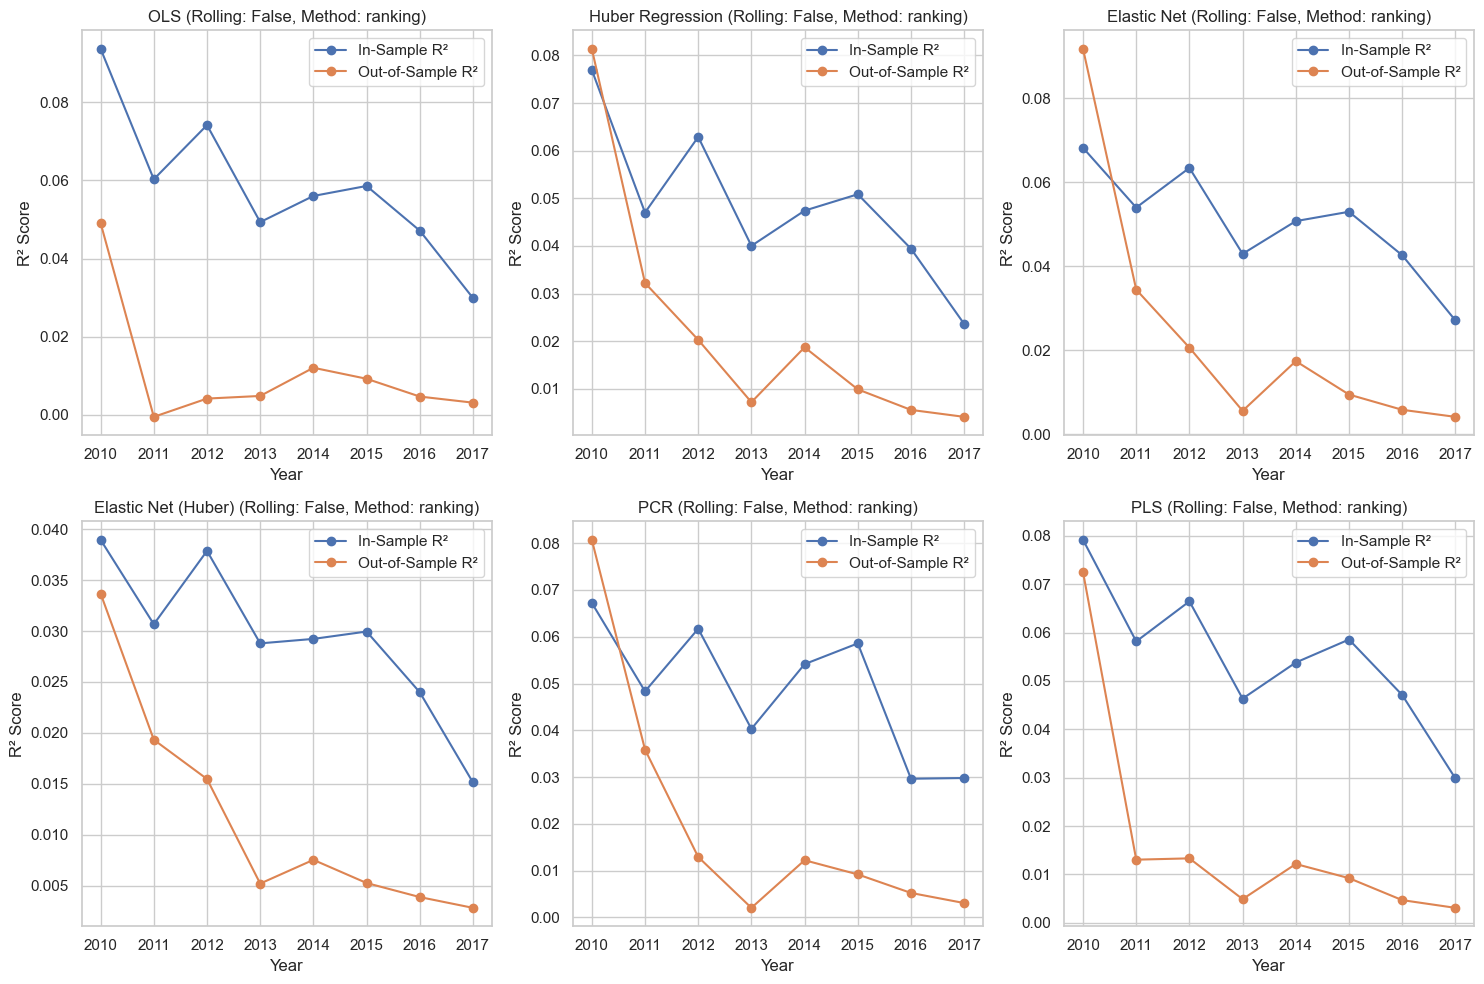

In [183]:
# 可视化配置
plot_r2_over_time(results, model_names, False, 'ranking')

#### 2. 不同模型样本外总$R^2$的比较

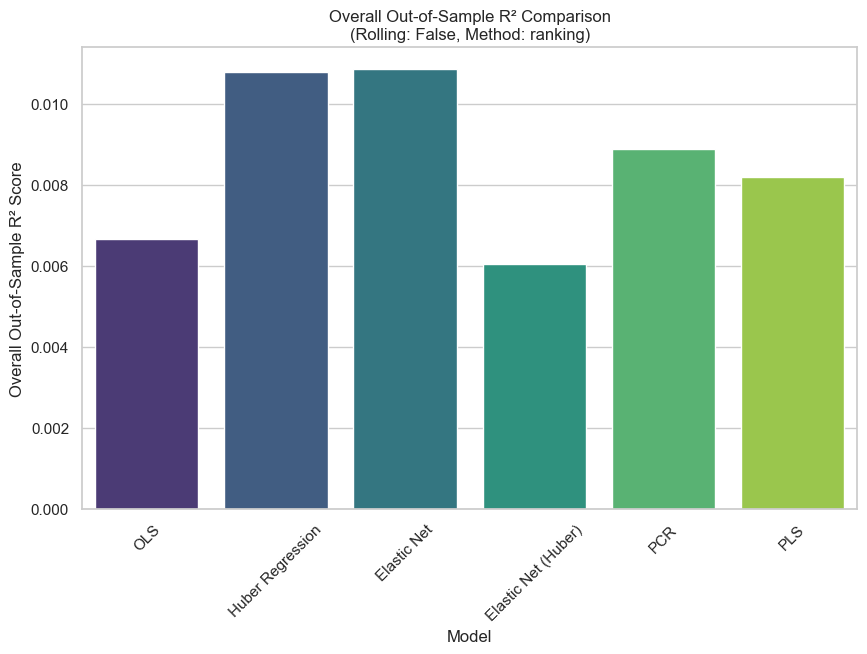

In [184]:
plot_overall_r2_comparison(results, model_names, False, 'ranking')

#### 3. 不同模型随时间变化样本外$R^2$的比较

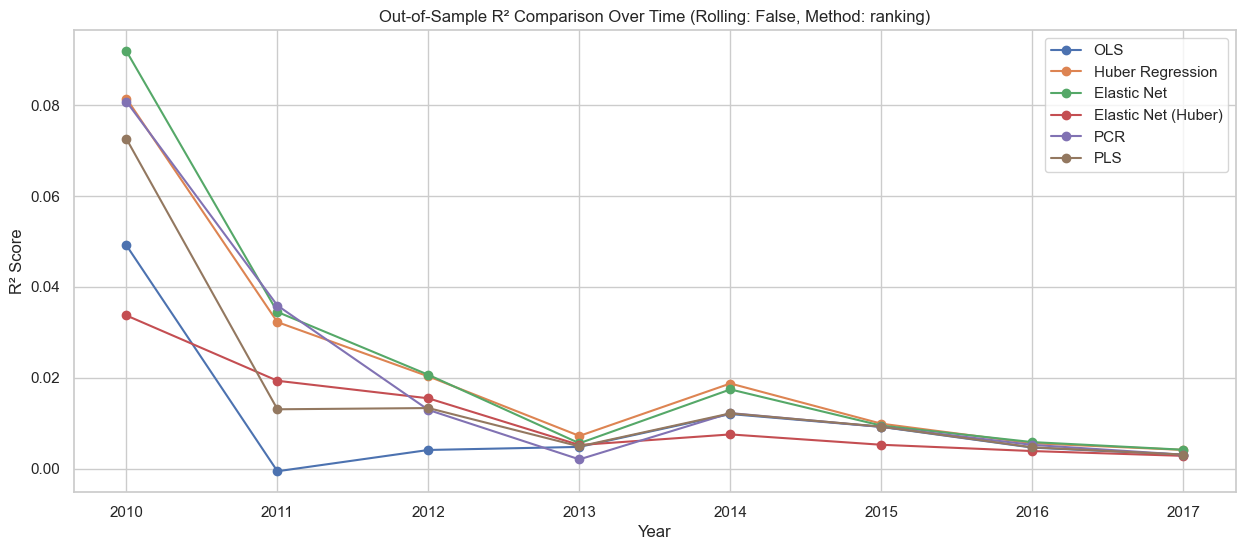

In [185]:
plot_r2_comparison_over_time(results, model_names, False, 'ranking')

### 二、训练集固定的方法下，使用排名标准化结果

#### 1. 不同模型随时间变化的样本内外$R^2$的变换

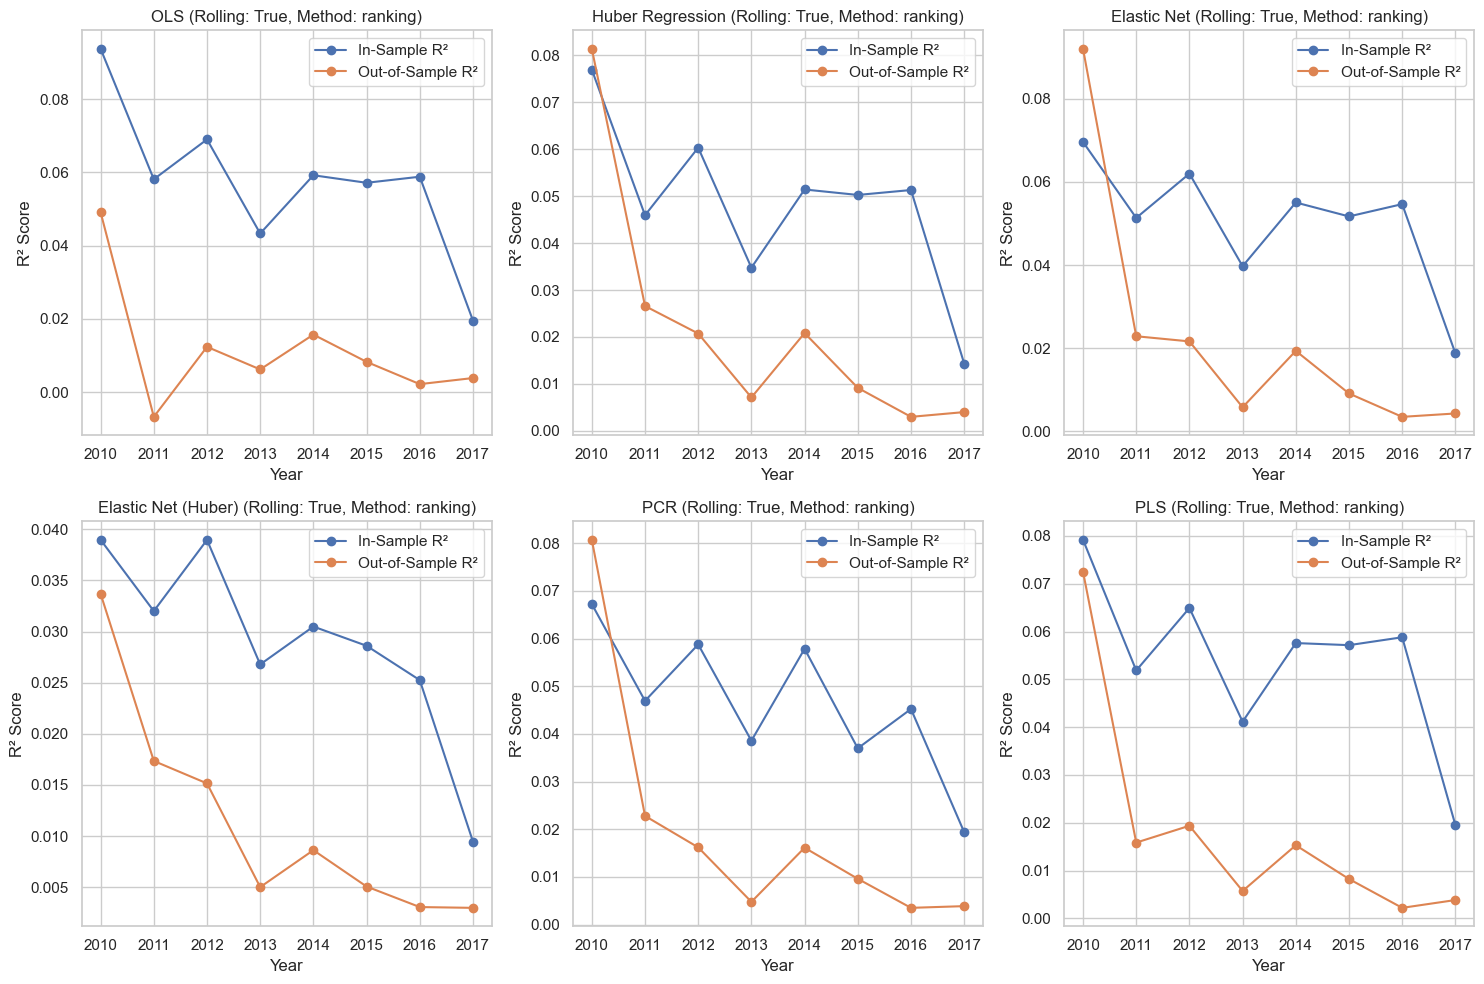

In [186]:
# 可视化配置
plot_r2_over_time(results, model_names, True, 'ranking')

#### 2. 不同模型样本外总$R^2$的比较

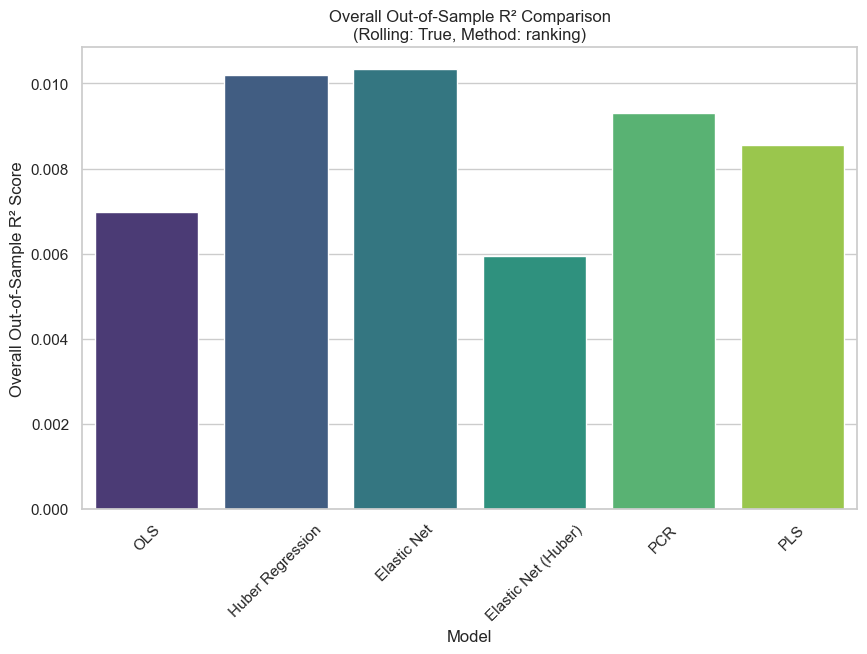

In [187]:
plot_overall_r2_comparison(results, model_names, True, 'ranking')

#### 3. 不同模型随时间变化样本外$R^2$的比较

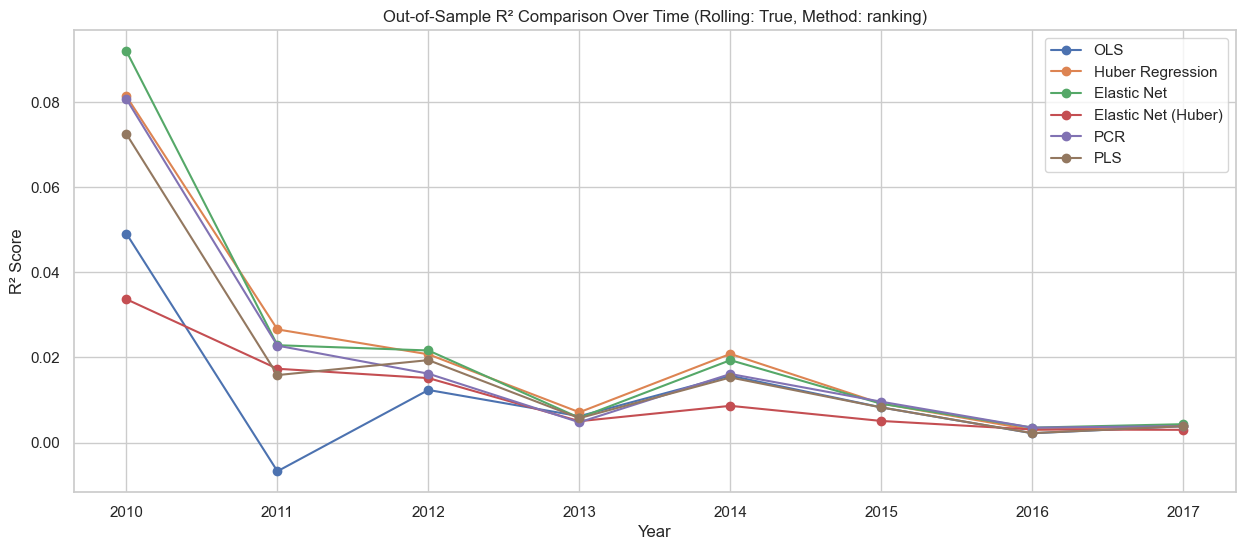

In [188]:
plot_r2_comparison_over_time(results, model_names, True, 'ranking')

### 三、训练集逐步增大的方法下，使用均值标准差标准化结果

#### 1. 不同模型随时间变化的样本内外$R^2$的变换

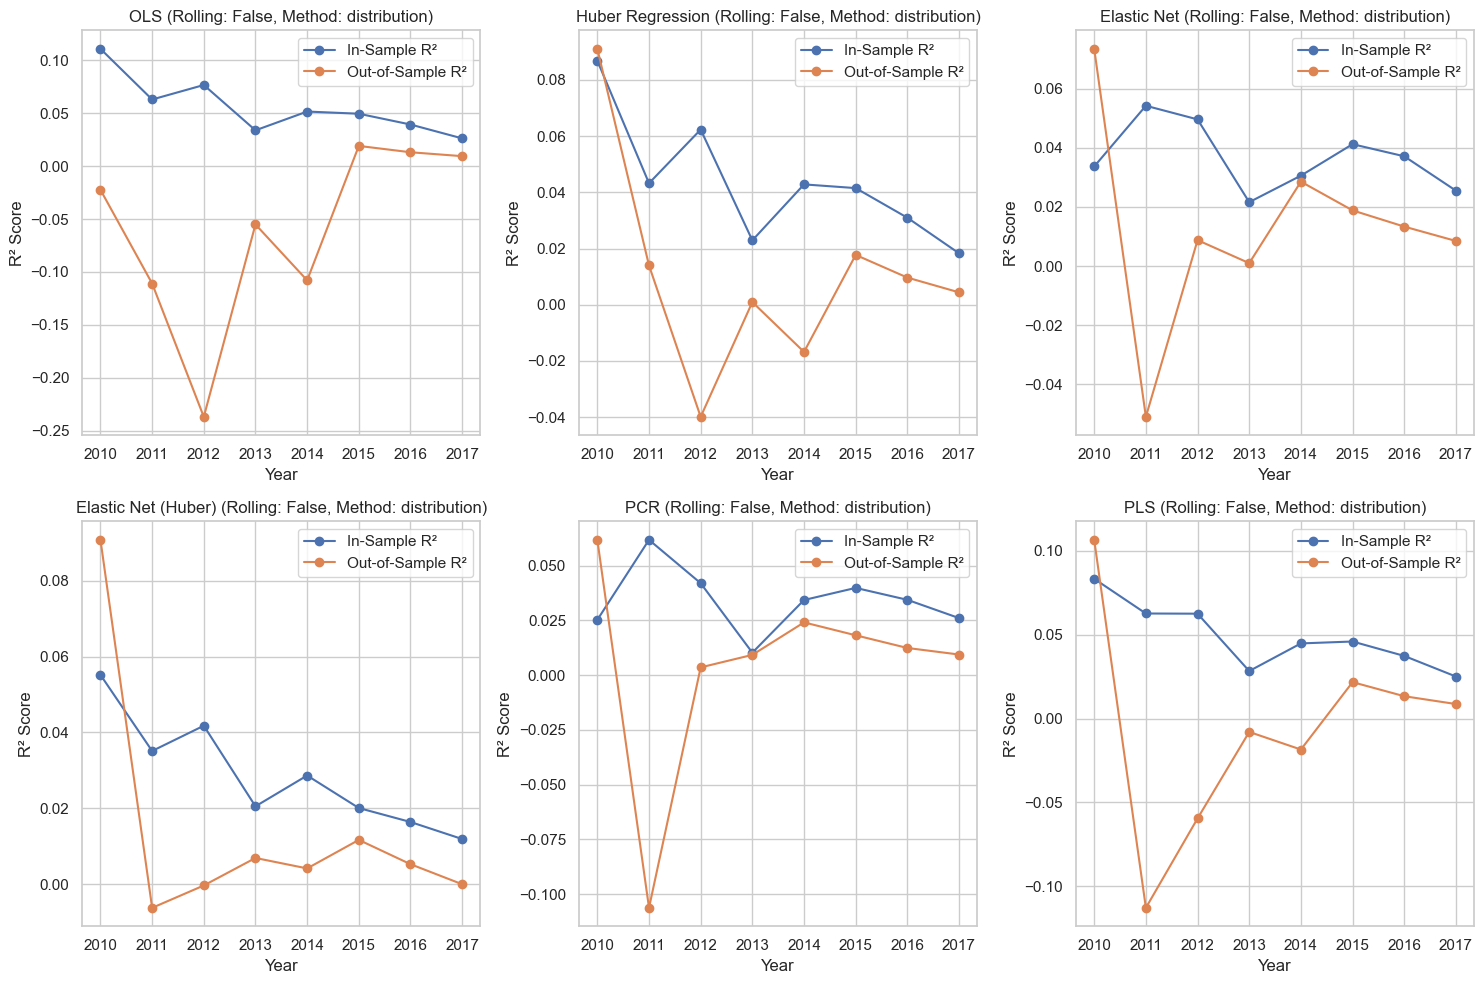

In [189]:
# 可视化配置
plot_r2_over_time(results, model_names, False, 'distribution')

#### 2. 不同模型样本外总$R^2$的比较

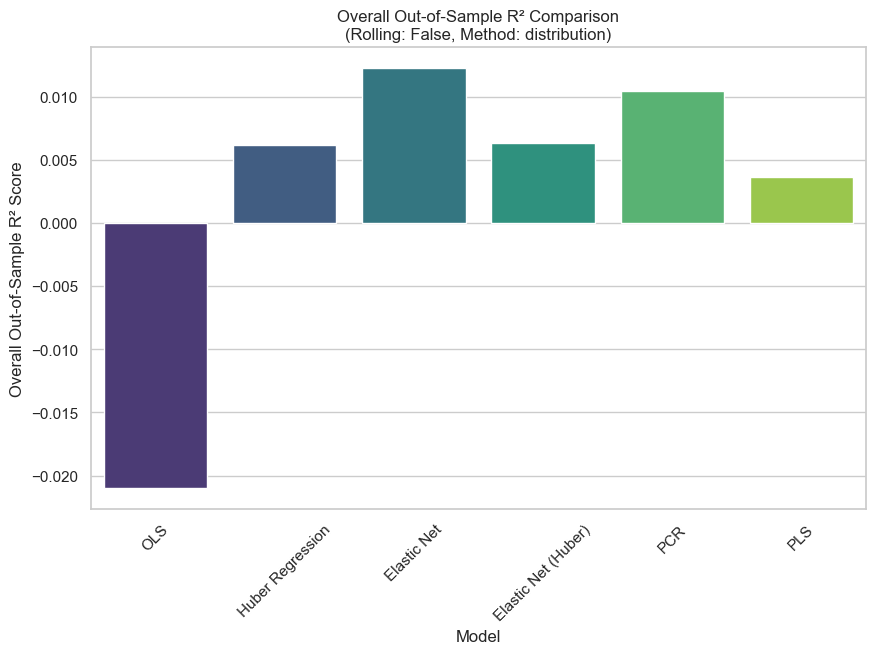

In [190]:
plot_overall_r2_comparison(results, model_names, False, 'distribution')

#### 3. 不同模型随时间变化样本外$R^2$的比较

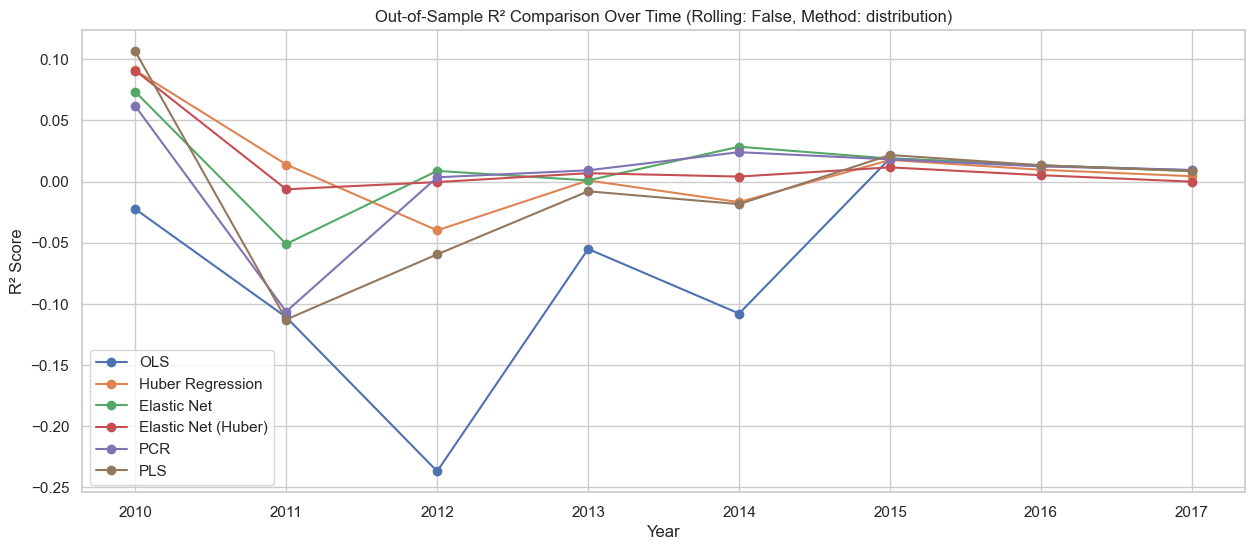

In [191]:
plot_r2_comparison_over_time(results, model_names, False, 'distribution')

### 四、训练集固定的方法下，使用均值标准差标准化结果

#### 1. 不同模型随时间变化的样本内外$R^2$的变换

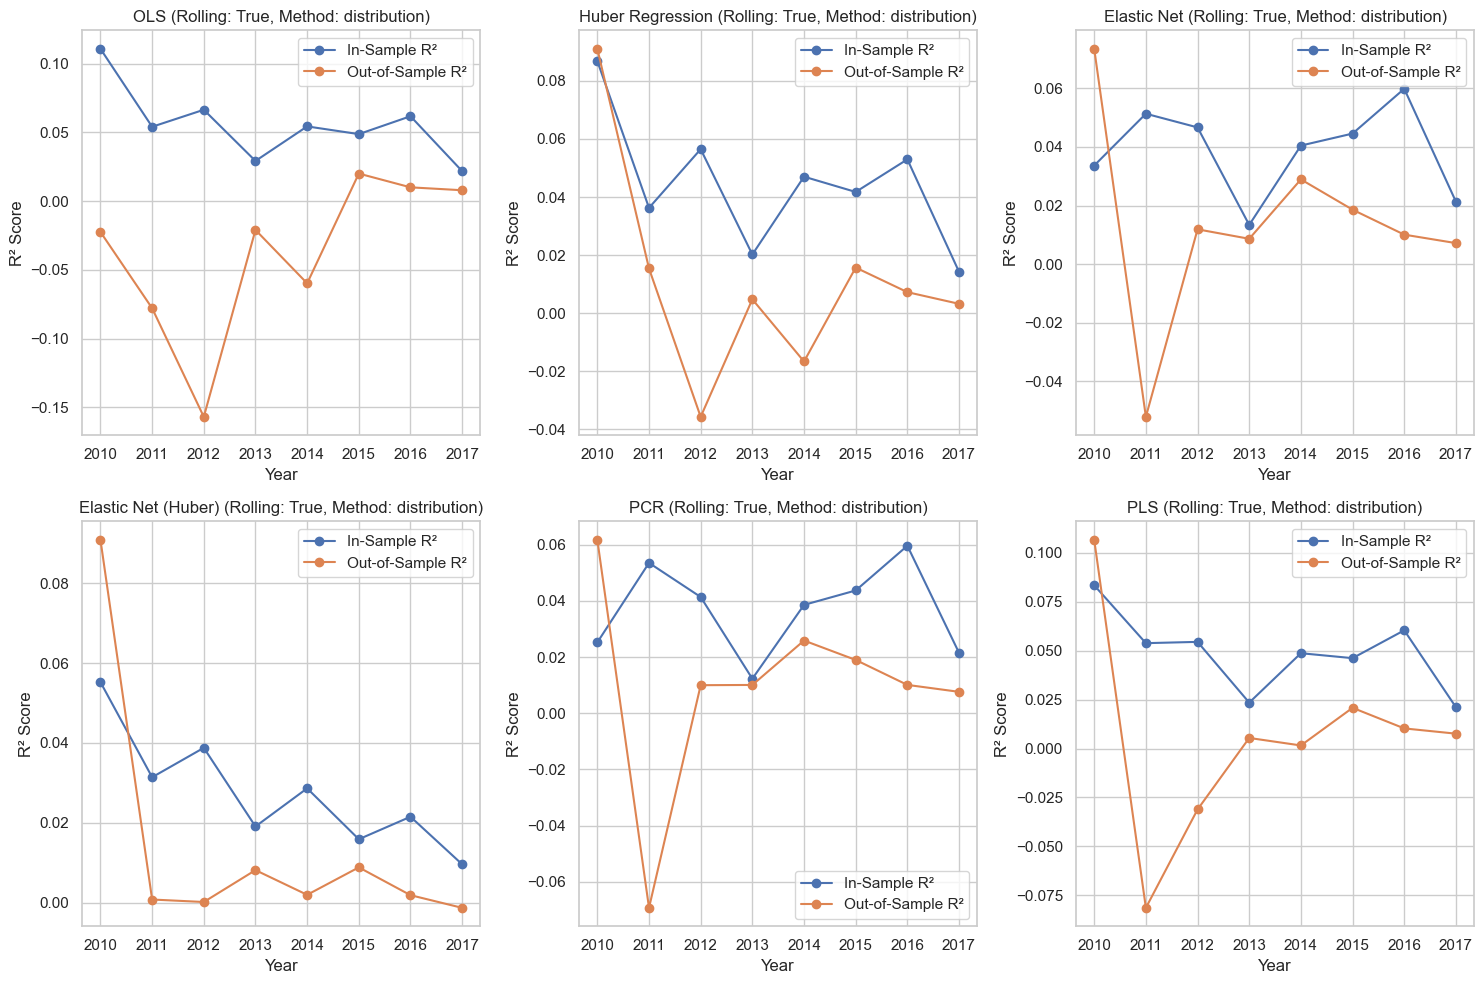

In [192]:
# 可视化配置
plot_r2_over_time(results, model_names, True, 'distribution')

#### 2. 不同模型样本外总$R^2$的比较

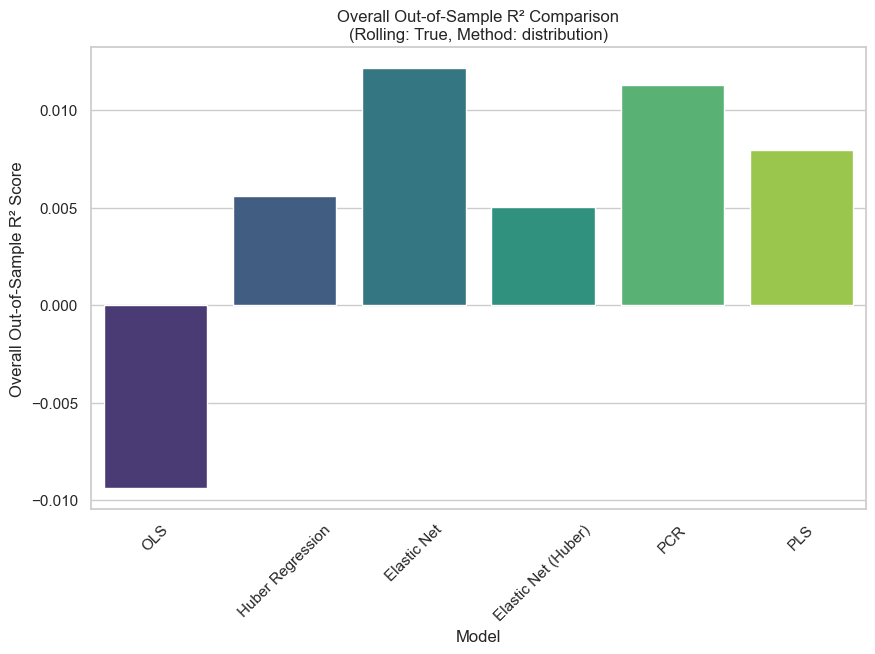

In [193]:
plot_overall_r2_comparison(results, model_names, True, 'distribution')

#### 3. 不同模型随时间变化样本外$R^2$的比较

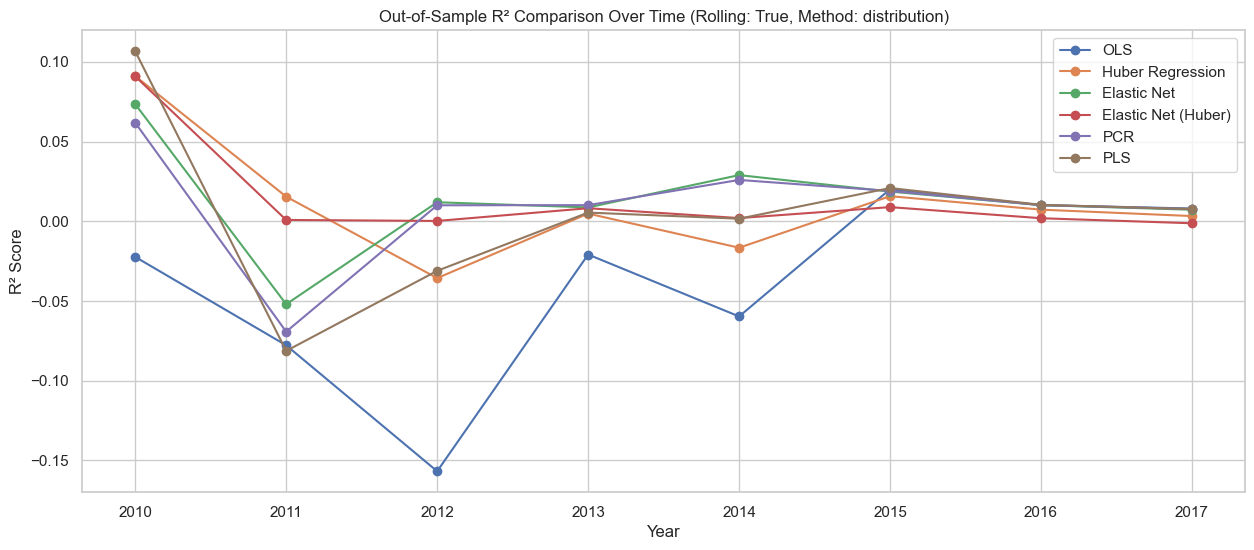

In [194]:
plot_r2_comparison_over_time(results, model_names, True, 'distribution')

### 不同数据处理方法间的比较

#### 样本内$R^2$随时间变化的比较

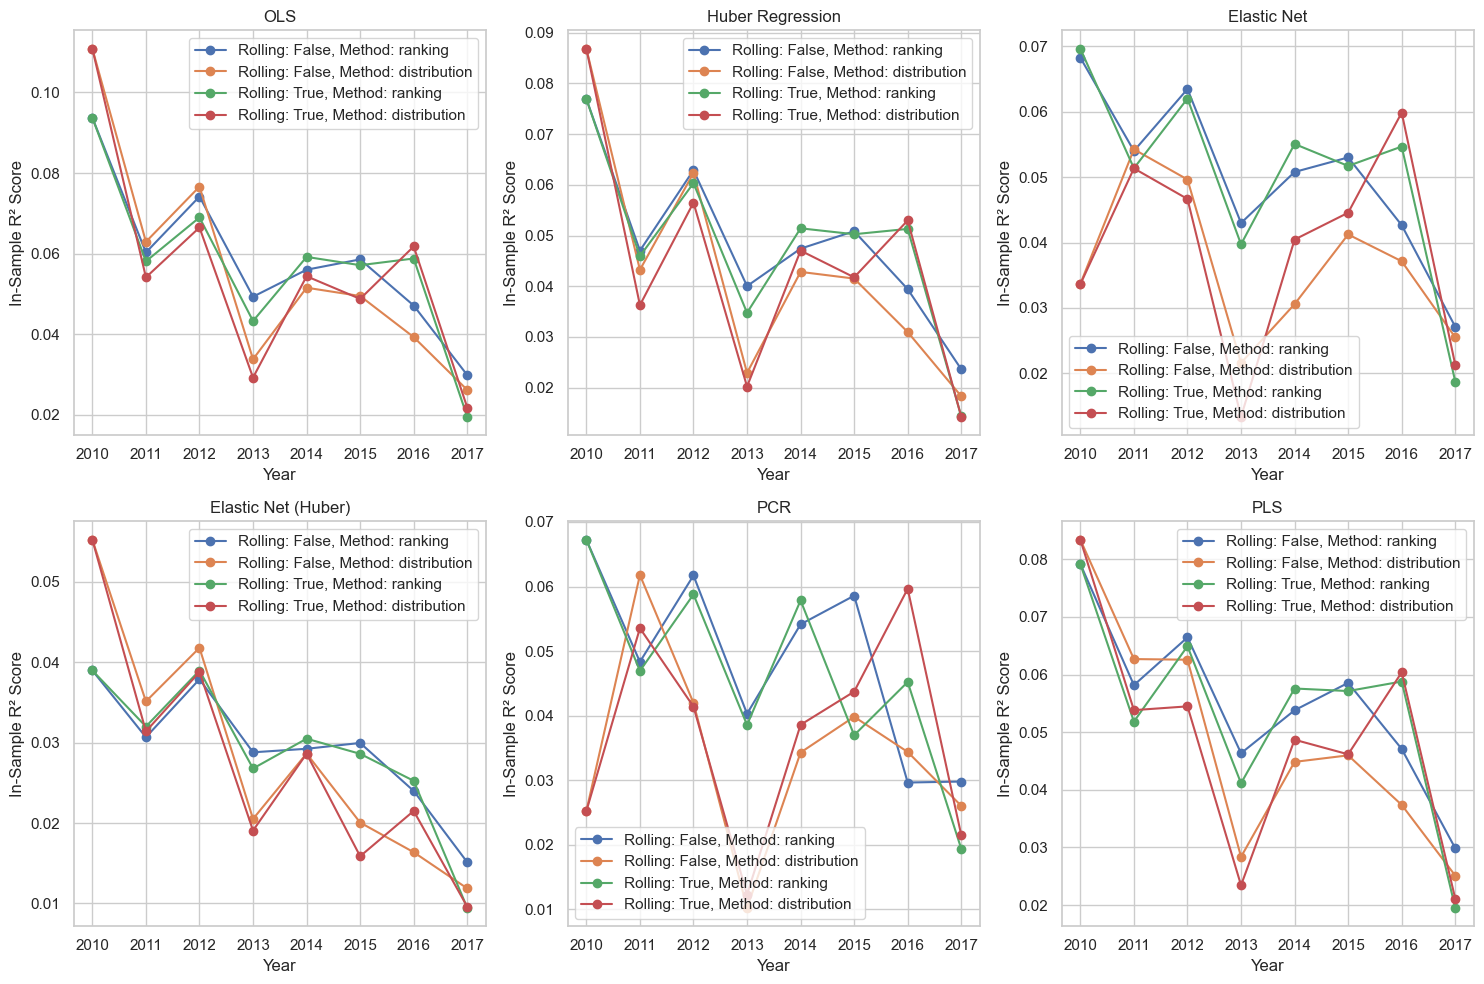

In [198]:
def plot_r2_in_comparison_over_time(data_dict, model_names, layout=(2, 3)):
    plt.figure(figsize=(15, 10))

    for i, model_name in enumerate(model_names):
        plt.subplot(layout[0], layout[1], i+1)

        for rolling in ['False', 'True']:
            for method in ['ranking', 'distribution']:
                r2_scores = extract_r2_scores(data_dict, model_name, rolling, method)
                years = [score[0] for score in r2_scores[:-1]]
                r2_in = [score[1] for score in r2_scores[:-1]]
                label = f'Rolling: {rolling}, Method: {method}'
                plt.plot(years, r2_in, marker='o', label=label)

        plt.title(model_name)
        plt.xlabel('Year')
        plt.ylabel('In-Sample R² Score')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# 可视化所有模型的样本内 R² 随时间变化
plot_r2_in_comparison_over_time(results, model_names)

#### 样本外$R^2$随时间变化的比较

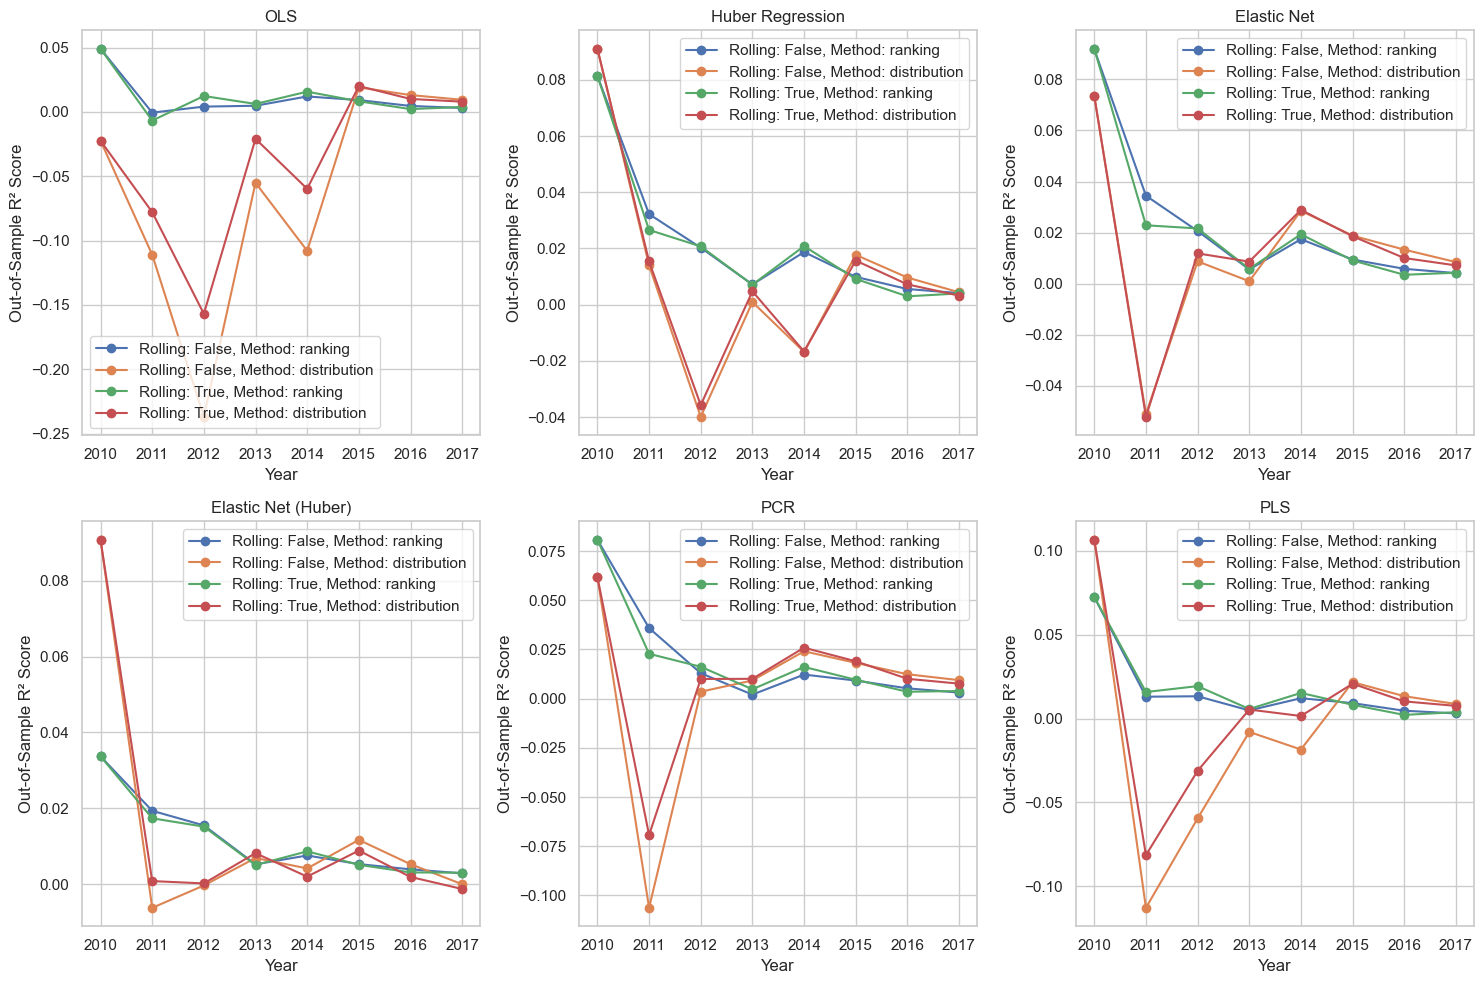

In [199]:
def plot_r2_out_comparison_over_time(data_dict, model_names, layout=(2, 3)):
    plt.figure(figsize=(15, 10))

    for i, model_name in enumerate(model_names):
        plt.subplot(layout[0], layout[1], i+1)

        for rolling in ['False', 'True']:
            for method in ['ranking', 'distribution']:
                r2_scores = extract_r2_scores(data_dict, model_name, rolling, method)
                years = [score[0] for score in r2_scores[:-1]]
                r2_out = [score[2] for score in r2_scores[:-1]]
                label = f'Rolling: {rolling}, Method: {method}'
                plt.plot(years, r2_out, marker='o', label=label)

        plt.title(model_name)
        plt.xlabel('Year')
        plt.ylabel('Out-of-Sample R² Score')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# 可视化所有模型的样本外 R² 随时间变化
plot_r2_out_comparison_over_time(results, model_names)


#### 总体$R^2$的比较

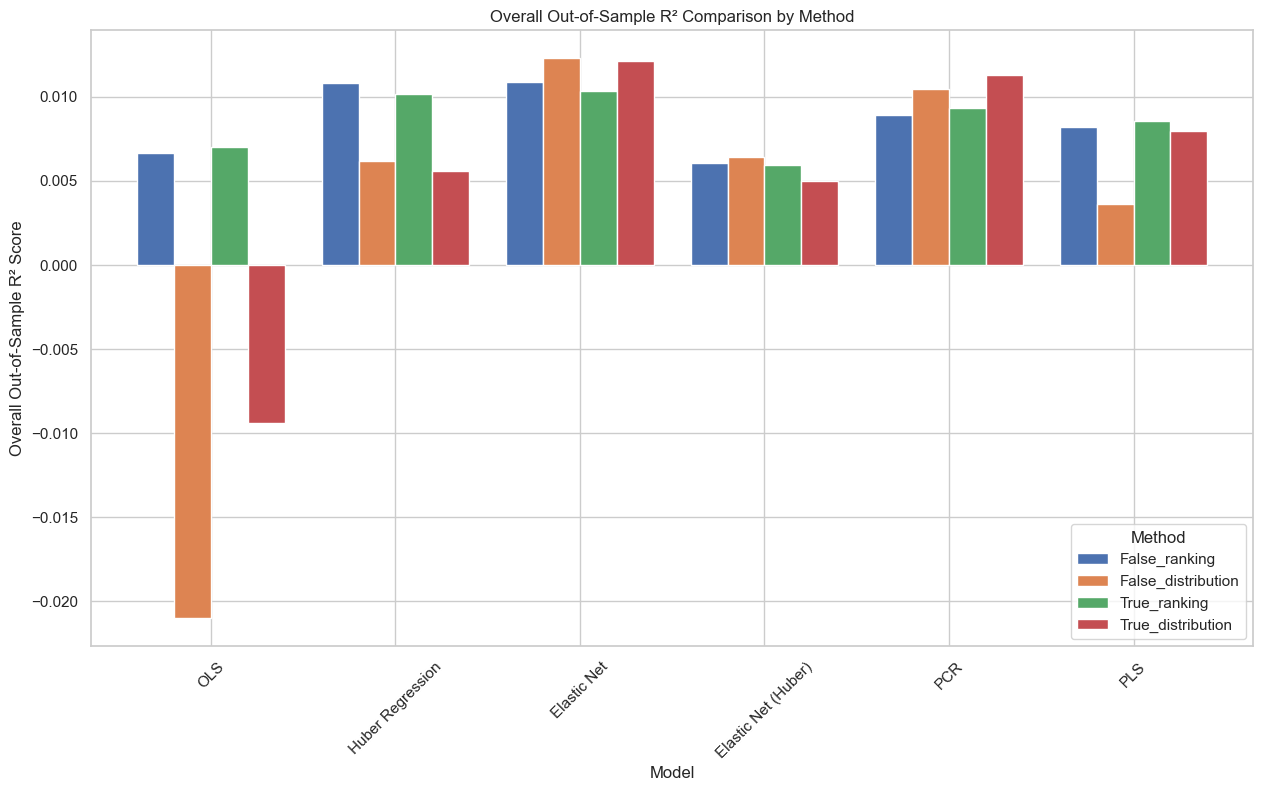

In [201]:
def plot_overall_r2_comparison_by_method(data_dict, model_names):
    overall_r2_scores = {method: [] for method in ['False_ranking', 'False_distribution', 'True_ranking', 'True_distribution']}
    
    for model_name in model_names:
        for rolling in ['False', 'True']:
            for method in ['ranking', 'distribution']:
                r2_scores = extract_r2_scores(data_dict, model_name, rolling, method)
                overall_r2 = r2_scores[-1][1]  # 提取总体样本外 R² 分数
                overall_r2_scores[f'{rolling}_{method}'].append(overall_r2)

    # 构建数据框架以进行绘图
    df = pd.DataFrame(overall_r2_scores, index=model_names)

    df.plot(kind='bar', figsize=(15, 8), width=0.8)
    plt.title('Overall Out-of-Sample R² Comparison by Method')
    plt.xlabel('Model')
    plt.ylabel('Overall Out-of-Sample R² Score')
    plt.xticks(rotation=45)
    plt.legend(title='Method')
    plt.show()

# 可视化所有模型的总体样本外 R² 比较
plot_overall_r2_comparison_by_method(results, model_names)
